# **04 - Feature Engineering**

## Objectives

* Engineer features to improve the predictive power of the dataset and prepare it for building a regression model to predict house prices.

## Inputs

* Train set: `outputs/datasets/cleaned/train_set.parquet`
* Test set: `outputs/datasets/cleaned/test_set.parquet`

## Outputs

* A list of final features selected for the regression model.
* Train and test sets with engineered features.


---

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues'

## Section 1: Load Clean Data and Data Profiling

### 1.1 Load Clean Data

We load the cleaned datasets (`train_set.parquet` and `test_set.parquet`) to ensure they are ready for feature engineering. Missing values are identified and handled to maintain data integrity and avoid issues during modeling.

#### TrainSet

In [4]:
import pandas as pd
TrainSet = pd.read_parquet("outputs/datasets/cleaned/train_set.parquet")
TrainSet.head(5)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1314       0.0           3.0           No         922          Rec   
1       799     772.0           3.0           No           0          Unf   
2       796       0.0           2.0           No           0          Unf   
3       981     787.0           3.0           No         569          ALQ   
4      1026     665.0           3.0           No         218          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        392         294          RFn       1957.0  ...     8400        70.0   
1        799         380          RFn       1993.0  ...     7837        59.0   
2        796           0         None          0.0  ...     8777        67.0   
3        162         240          Unf       1939.0  ...     7200        60.0   
4        808         308          Unf       1924.0  ...     5000        50.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            6            5         1314       1957   
1         0.0           40            7            6          799       1993   
2         0.0            0            7            5          796       1910   
3       252.0            0            7            5          731       1937   
4         0.0            0            6            5         1026       1924   

   YearRemodAdd  SalePrice  
0          1957     145000  
1          1994     178000  
2          1950      85000  
3          1950     175000  
4          1950     127000  

[5 rows x 22 columns]

#### Test set

In [5]:
TestSet = pd.read_parquet("outputs/datasets/cleaned/test_set.parquet")
TestSet.head(5)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1068       0.0           3.0           No         663          GLQ   
1      1500       0.0           3.0           Av        1032          GLQ   
2      1028       0.0           2.0           No           0          Unf   
3      1004       0.0           3.0           No         399          ALQ   
4      1620       0.0           2.0           Gd        1022          GLQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        396         264          RFn       1963.0  ...     8414        70.0   
1        431         712          RFn       1994.0  ...    12256        98.0   
2       1008         360          Unf       1927.0  ...     8960        56.0   
3        605         420         None       1950.0  ...     5000        50.0   
4        598         912          Fin       2008.0  ...    12898        89.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            8            6         1059       1963   
1       362.0           32            5            8         1463       1994   
2         0.0            0            6            5         1008       1927   
3         0.0           24            7            6         1004       1947   
4        70.0            0            5            9         1620       2007   

   YearRemodAdd  SalePrice  
0          2003     154500  
1          1995     325000  
2          1950     115000  
3          1950     159000  
4          2008     315500  

[5 rows x 22 columns]

#### 1.1.1 Check Datasets for Missing Values

In [6]:
# Train set
print(f"TrainSet has: {TrainSet['GarageFinish'].isnull().sum()} missing values.")

# Test set
print(f"TestSet has: {TestSet['GarageFinish'].isnull().sum()} missing values.")

TrainSet has: 0 missing values.
TestSet has: 0 missing values.


### 1.3 Data Profiling

To get an overview of the `TrainSet` DataFrame, we generate an exploratory data analysis (EDA) report using `ydata_profiling`.

In [7]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df=TrainSet, minimal=True)
profile.to_notebook_iframe()

d:\Projects\milestone-project-heritage-housing-issues\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'display' from 'IPython.core.display' (d:\Projects\milestone-project-heritage-housing-issues\.venv\Lib\site-packages\IPython\core\display.py)

---

## Section 2: Feature Engineering

*This code was inspired by feature engineering in Walkthrough Project 2: Churnometer.*

### 2.1 Custom Function

Feature engineering is a critical step to enhance the predictive power of the dataset. We use a modular approach to systematically handle outliers, apply transformations to improve variable distributions, and encode categorical variables. This ensures the dataset is optimized for regression modeling.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer, PowerTransformer, BoxCoxTransformer, YeoJohnsonTransformer, ReciprocalTransformer
%matplotlib inline

# Set theme style
sns.set(style="darkgrid")

# Ignore warning
warnings.filterwarnings("ignore", category=FutureWarning)


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - Used for quick feature engineering on numerical and categorical variables
      to decide which transformation can better transform the distribution shape.
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions.
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop through each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # Create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers to respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """Check analysis type."""
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    """Check for missing values in the dataset."""
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """Set suffix columns according to analysis_type."""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    """Apply transformations based on the analysis type."""
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    """Evaluate transformations for each variable."""
    print(f"*** Variable Analyzed: {column}")
    print(f"*** Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")

# Categorical Plots
def DiagnosticPlots_Categories(df_feat_eng, col):
    """Plot diagnostics for categorical variables."""
    if col not in df_feat_eng.columns:
        raise ValueError(f"Column {col} is not a valid column in the DataFrame.")
    
    unique_categories = len(df_feat_eng[col].unique())
    palette = sns.color_palette("Spectral", n_colors=unique_categories)

    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df_feat_eng,
        x=col,
        palette=palette,
        order=df_feat_eng[col].value_counts().index
    )
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=14, y=1.05)
    plt.show()

# Numerical Plots
def DiagnosticPlots_Numerical(df, variable):
    """Plot diagnostics for numerical variables."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Histogram
    sns.histplot(data=df,
                x=variable,
                kde=True,
                element="step",
                ax=axes[0],
                color=sns.color_palette("Spectral")[0]
    )
    axes[0].set_title('Histogram', fontsize=8)

    # QQ-Plot
    stats.probplot(
        df[variable],
        dist="norm",
        plot=axes[1],
    )
    if len(axes[1].get_lines()) >= 2:
        axes[1].get_lines()[0].set_color(sns.color_palette("Spectral")[4])
        axes[1].get_lines()[1].set_color('black')
    axes[1].set_title('QQ Plot', fontsize=8)

    # Boxplot
    sns.boxplot(
        x=df[variable],
        ax=axes[2], 
        color=sns.color_palette("Spectral")[1]
    )    
    axes[2].set_title('Boxplot', fontsize=8)

    fig.suptitle(f"{variable}", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    """Apply ordinal encoding to categorical variables."""
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    """Apply Winsorization to handle outliers."""
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    """Apply numerical transformations."""
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### 2.2  Applying Feature Engineering

Next we will apply feature engineering techniques to prepare the `TrainSet` for modeling. This includes categorical encoding, numerical transformation and smart correlation selections.

#### 2.2.1 Categorical Encoding
Machine learning models require numerical inputs, so categorical variables are encoded using ordinal encoding. This method preserves the order of categories, which is important for variables like `GarageFinish` and `KitchenQual` that have a natural hierarchy.

We start by selecting the variables to be coded and display them.

In [13]:
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Create a separate DataFrame containing only the selected variables and display the three rows. This makes it easier to process and test the transformations.

In [14]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           No          Rec          RFn          TA
1           No          Unf          RFn          TA
2           No          Unf         None          TA

Call `FeatureEngineeringAnalysis` function to apply Ordinal Encoding to the selected variables. The `FeatureEngineeringAnalysis` function already contains diagnostic plots to evaluate the transformations. These will be run automatically when the function is called.

*** Variable Analyzed: BsmtExposure
*** Applied transformation: ['BsmtExposure_ordinal_encoder'] 



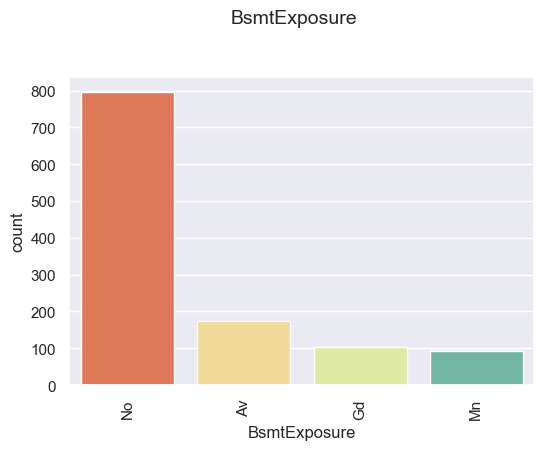

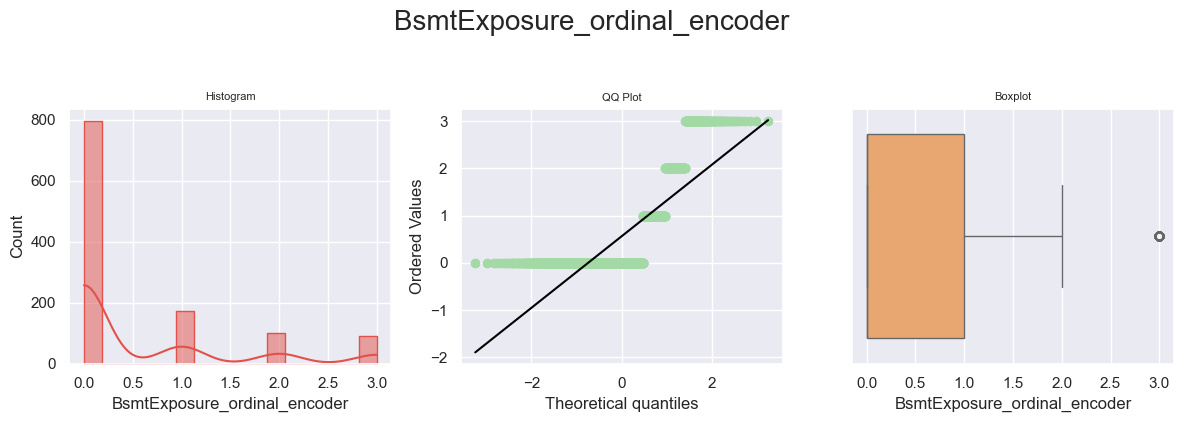



*** Variable Analyzed: BsmtFinType1
*** Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



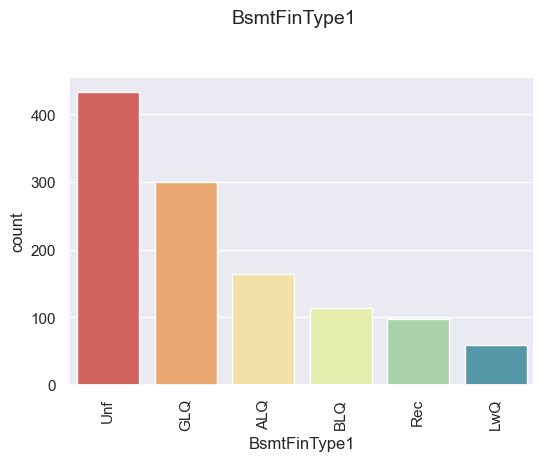

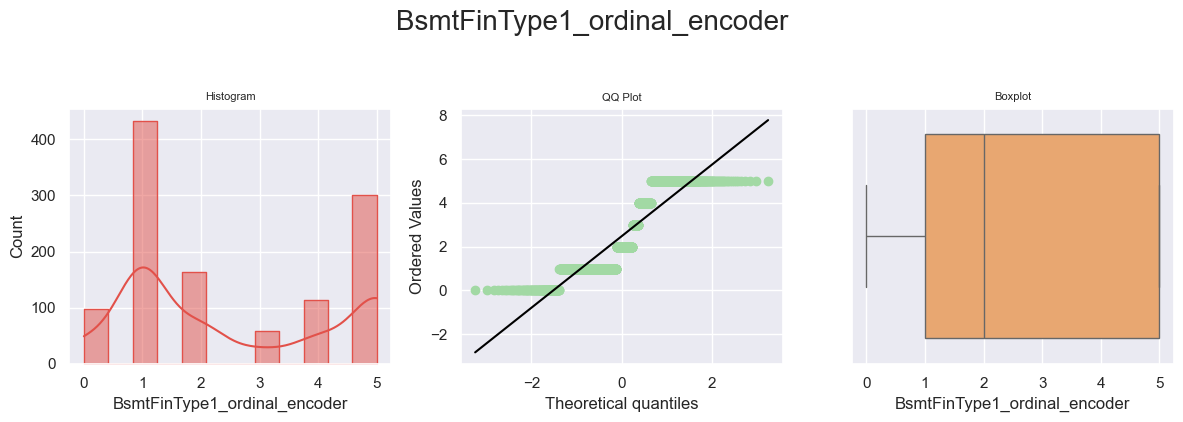



*** Variable Analyzed: GarageFinish
*** Applied transformation: ['GarageFinish_ordinal_encoder'] 



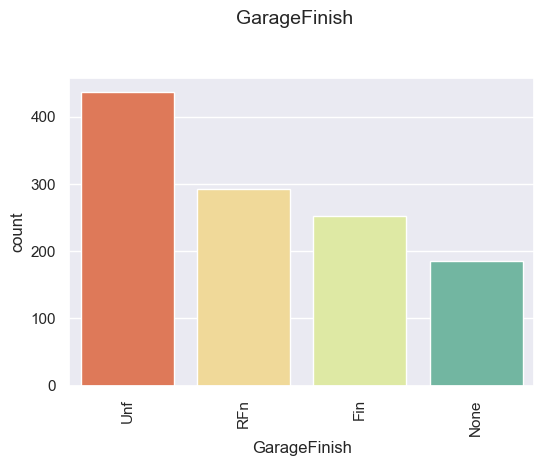

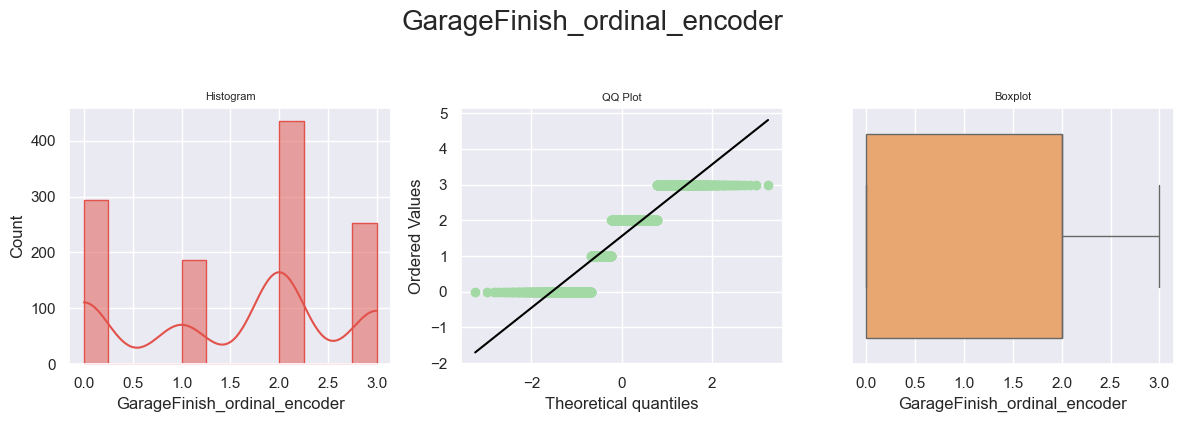



*** Variable Analyzed: KitchenQual
*** Applied transformation: ['KitchenQual_ordinal_encoder'] 



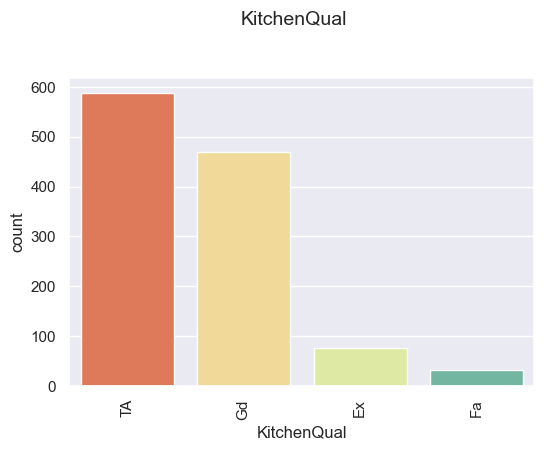

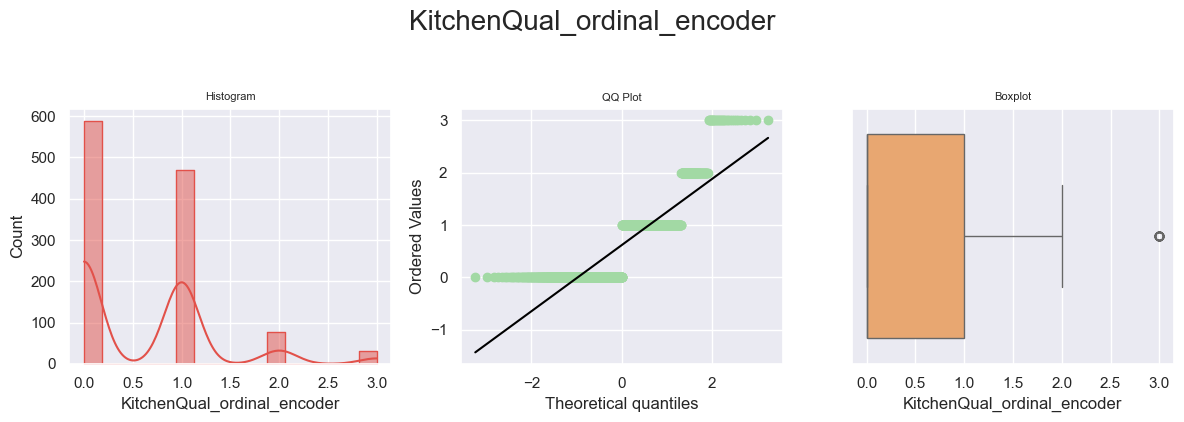

In [15]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

Apply the selected transformation to the Train and Test set.

In [16]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("*** Categorical encoding - ordinal transformation done!")

*** Categorical encoding - ordinal transformation done!


#### 2.2.2 Numerical Transformation

Select variables for numerical transformation.

In [17]:
variables_engineering = [
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea',
    'LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF'
    ]
variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'GarageArea',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF']

Create a separate DataFrame containing only the selected variables and display the three rows.

In [18]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  GrLivArea  LotArea  LotFrontage  GarageArea  \
0      1314       0.0       1314     8400         70.0         294   
1       799     772.0       1571     7837         59.0         380   
2       796       0.0        796     8777         67.0           0   

   MasVnrArea  OpenPorchSF  TotalBsmtSF  
0         0.0            0         1314  
1         0.0           40          799  
2         0.0            0          796

Call `FeatureEngineeringAnalysis` function to apply numerical transformations to the selected variables.

*** Variable Analyzed: 1stFlrSF
*** Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



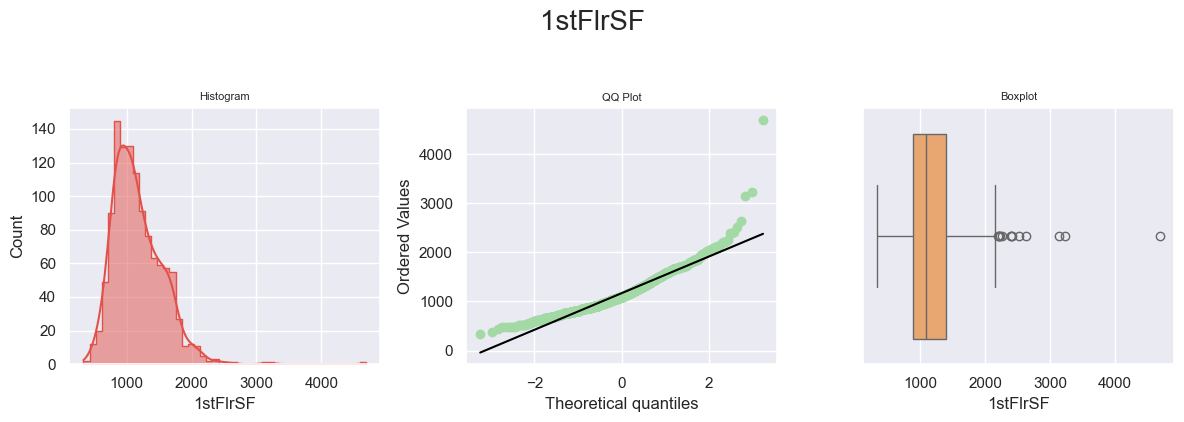

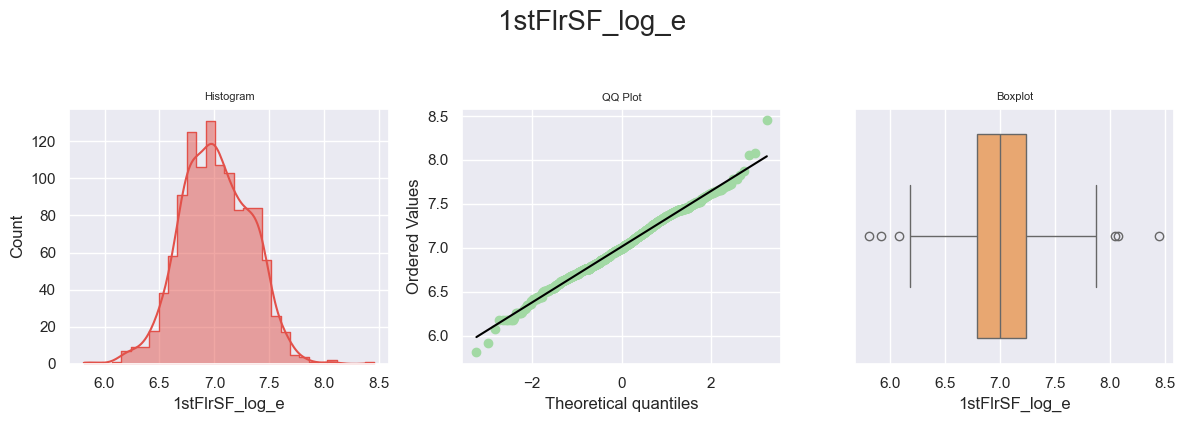

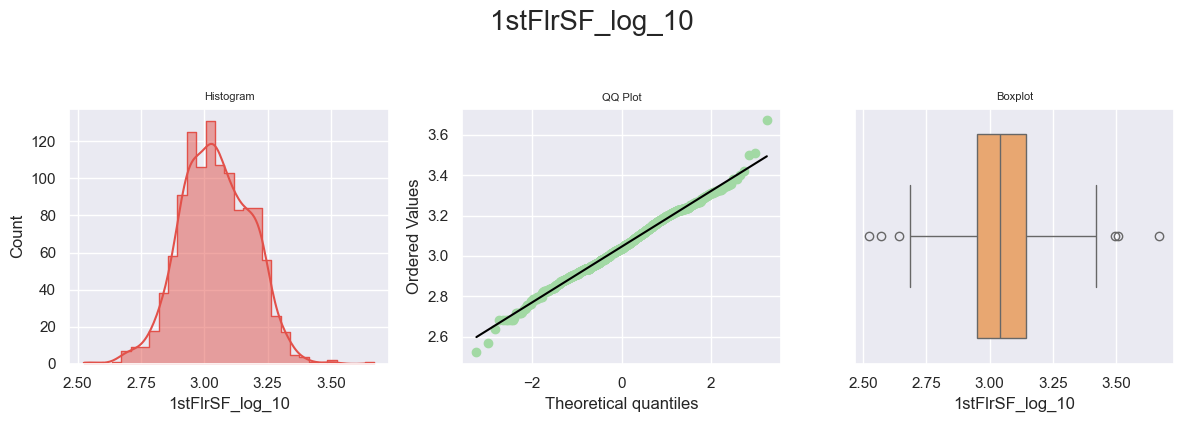

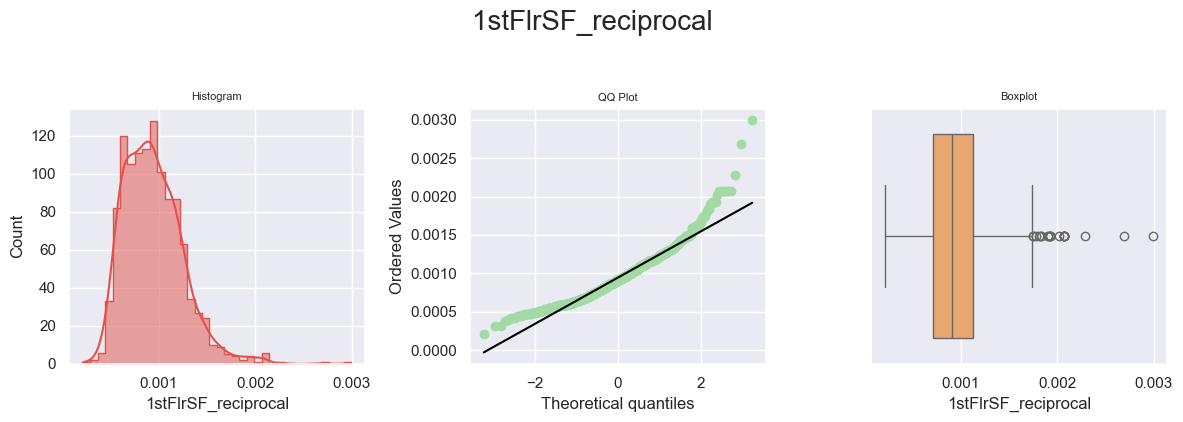

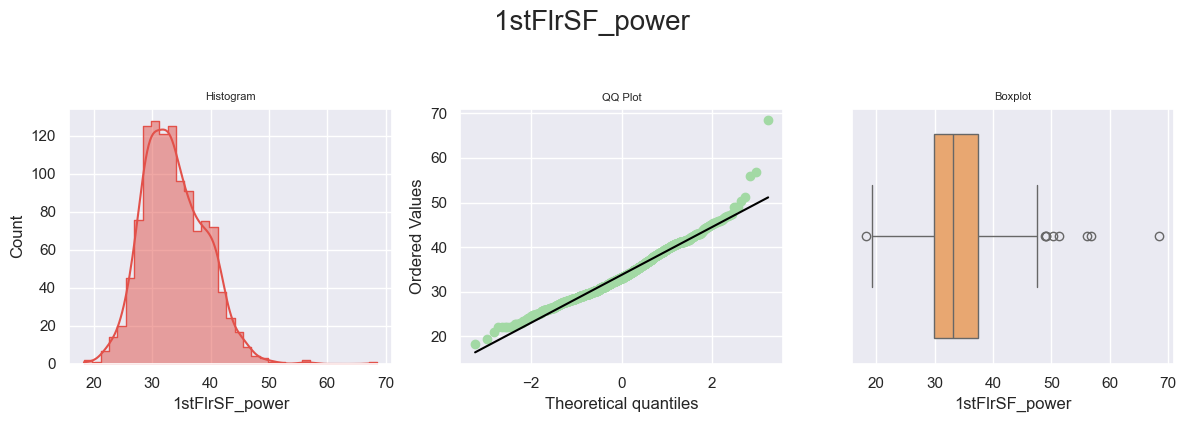

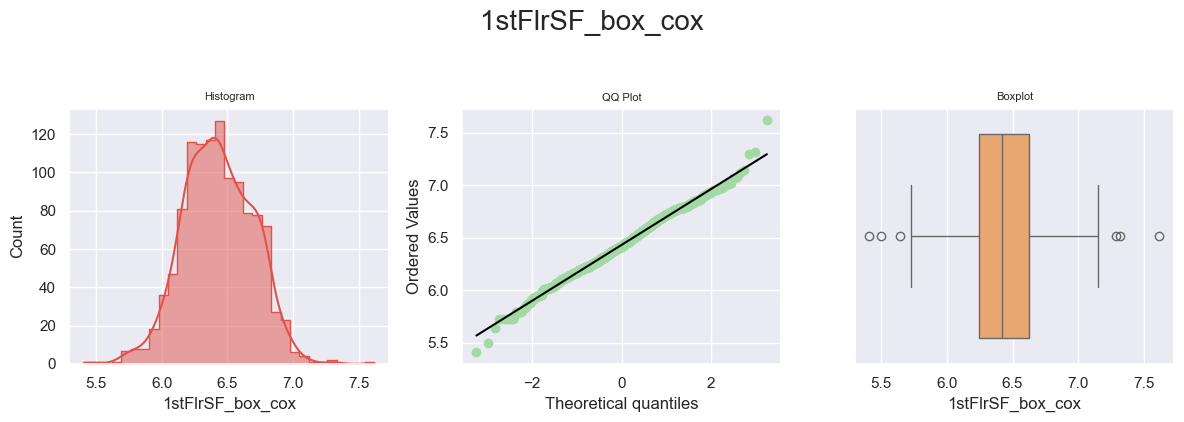

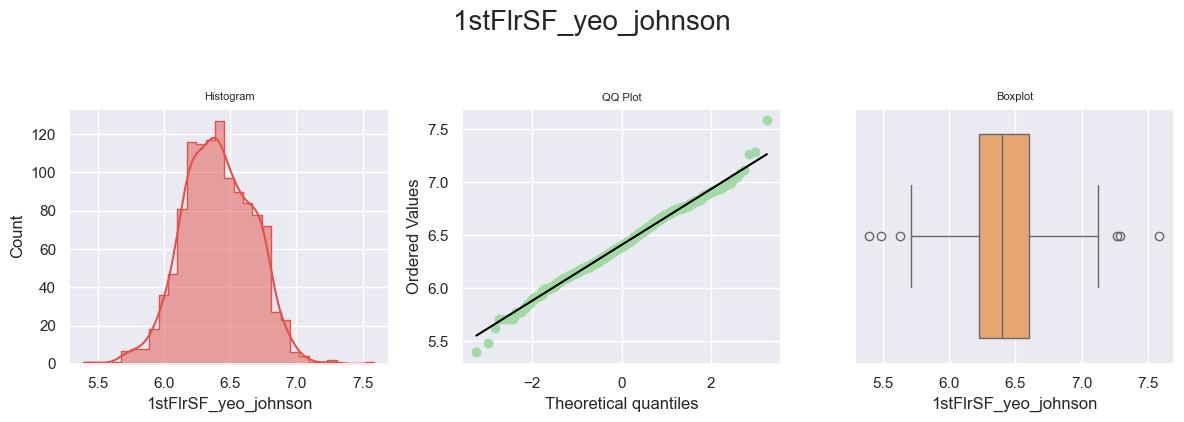



*** Variable Analyzed: 2ndFlrSF
*** Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



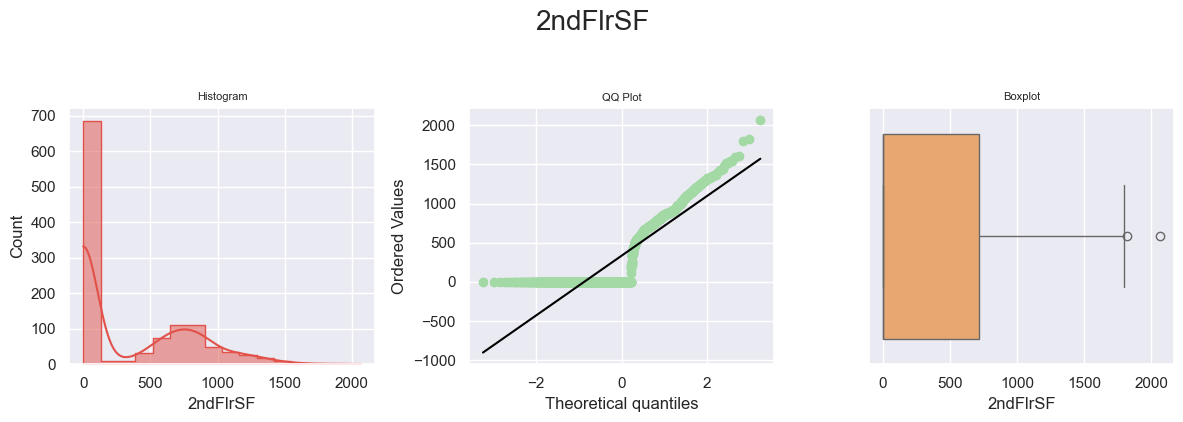

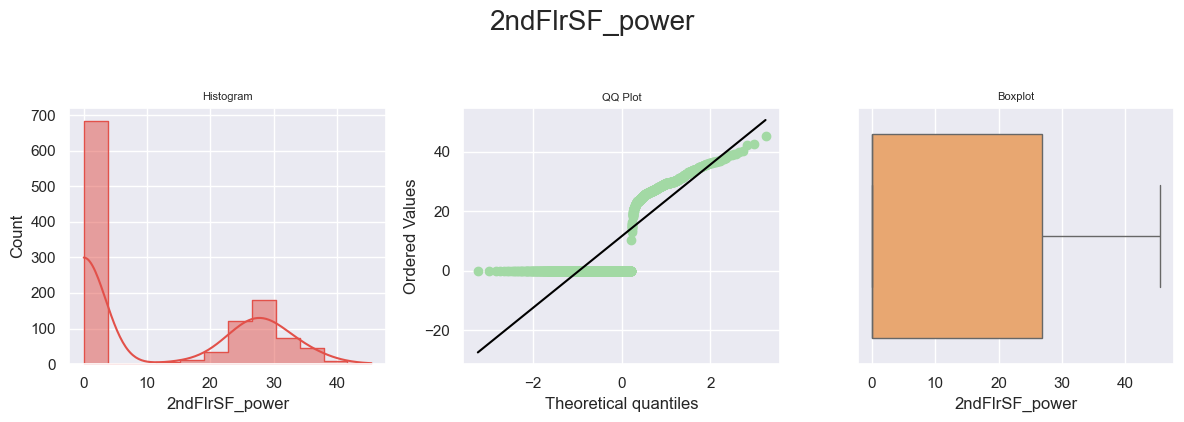

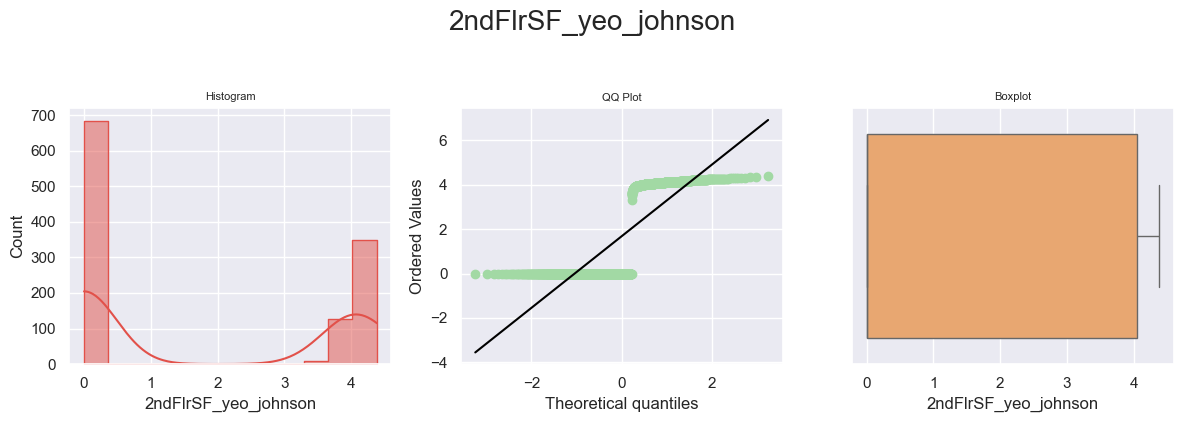



*** Variable Analyzed: GrLivArea
*** Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



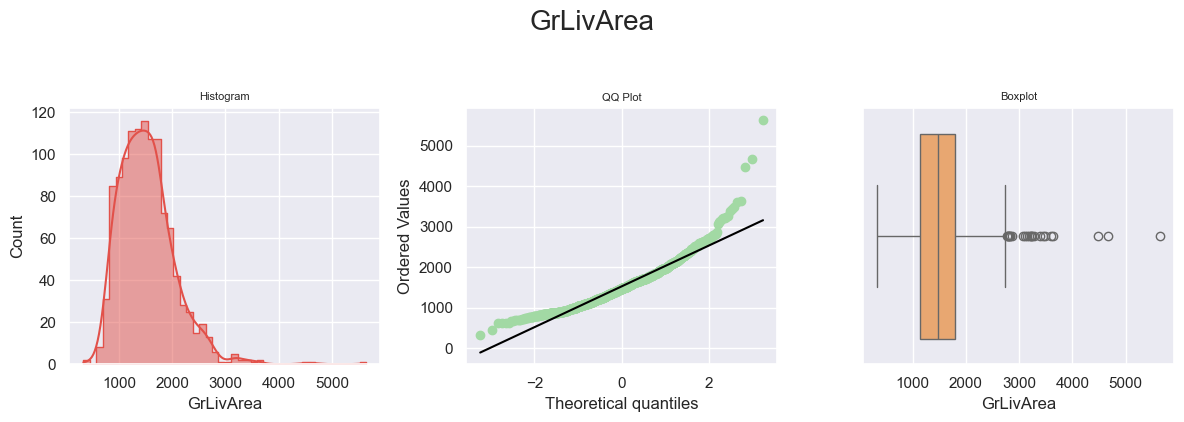

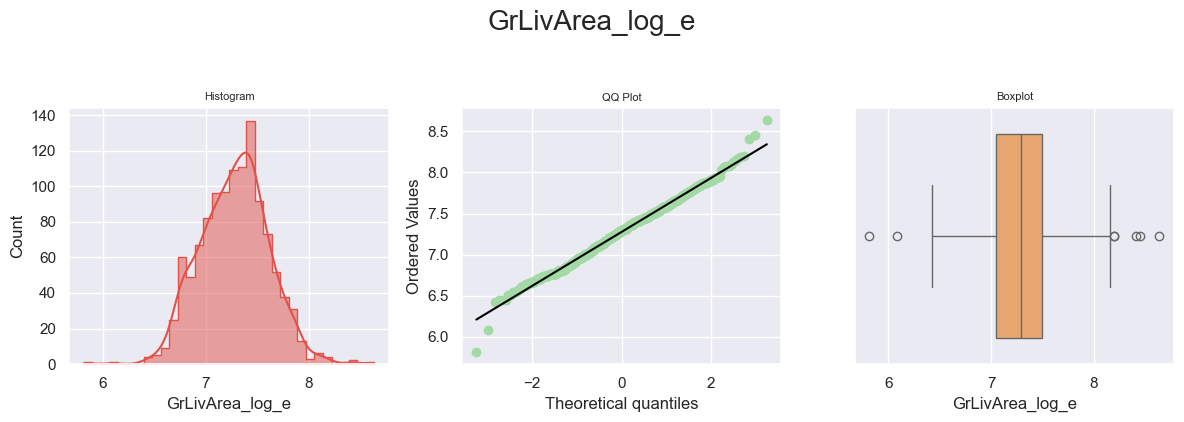

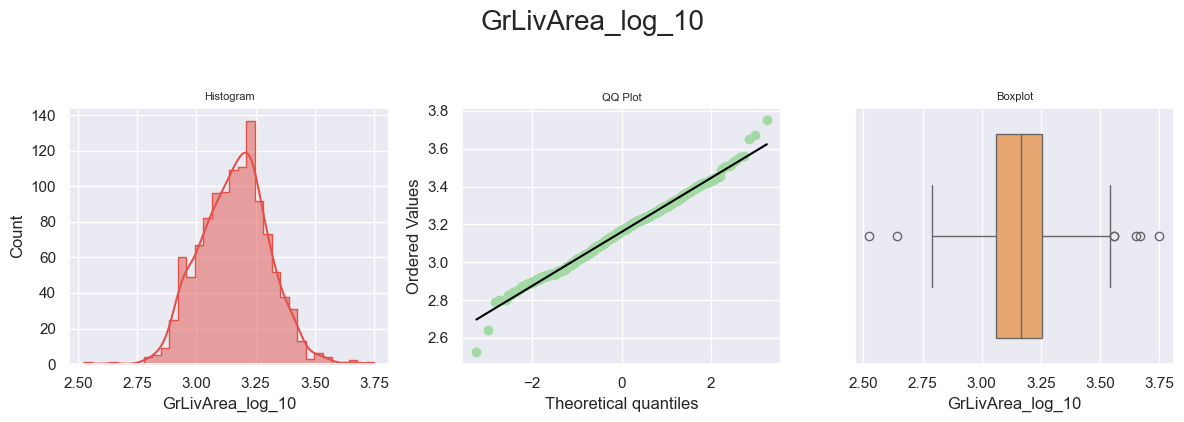

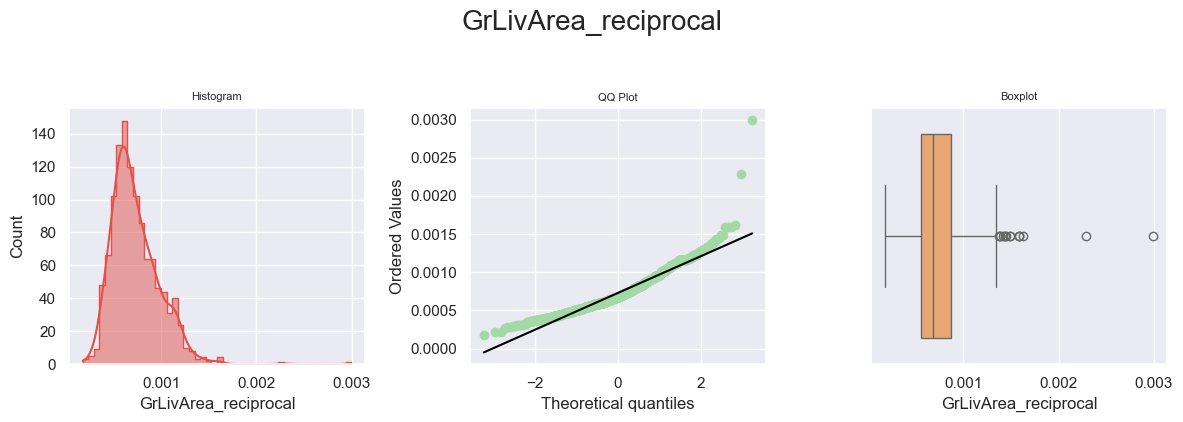

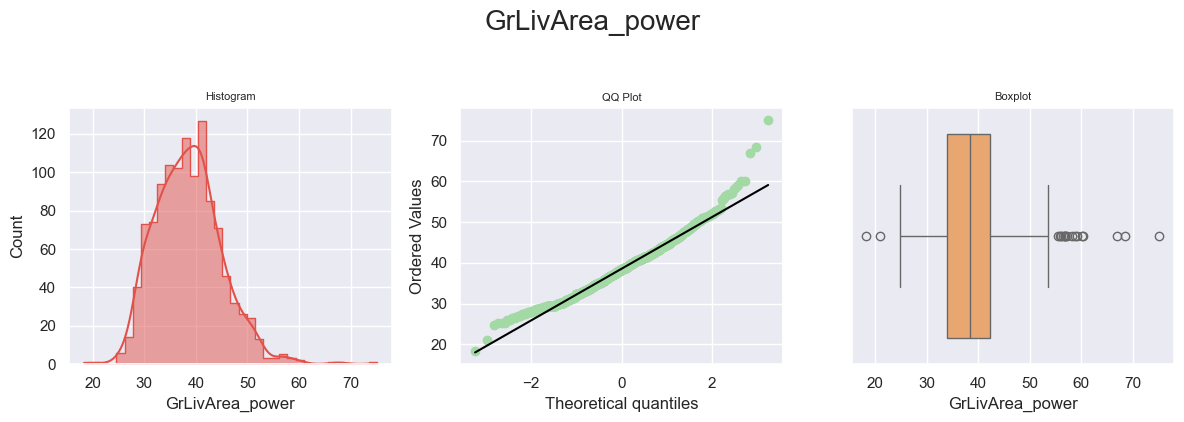

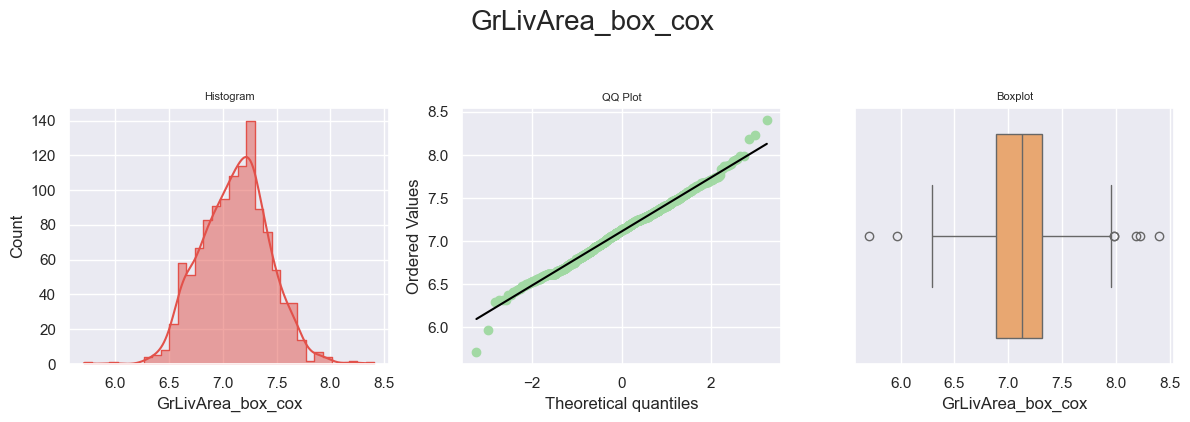

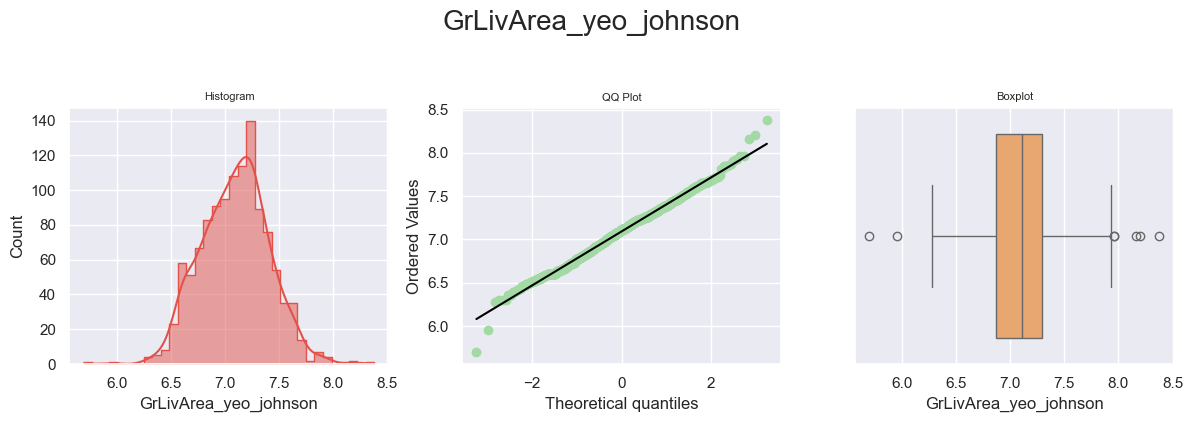



*** Variable Analyzed: LotArea
*** Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



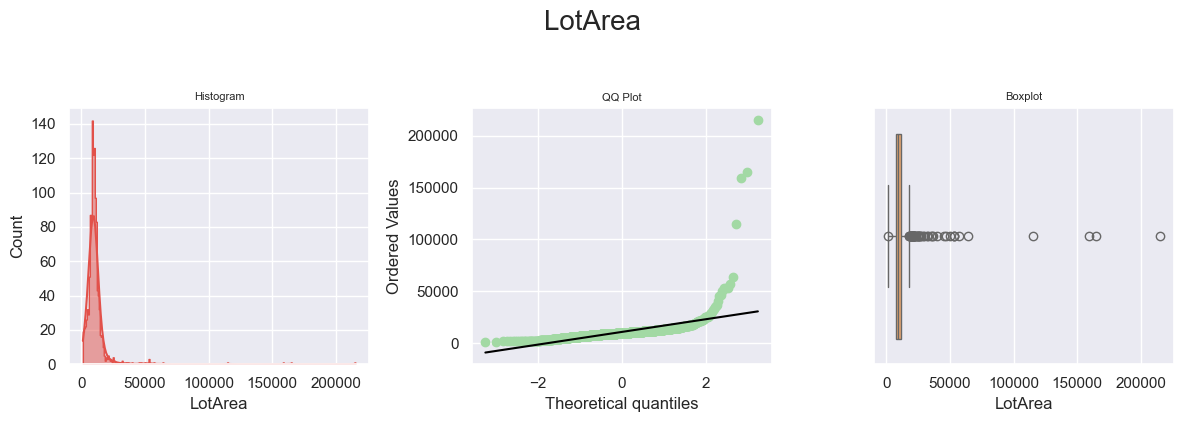

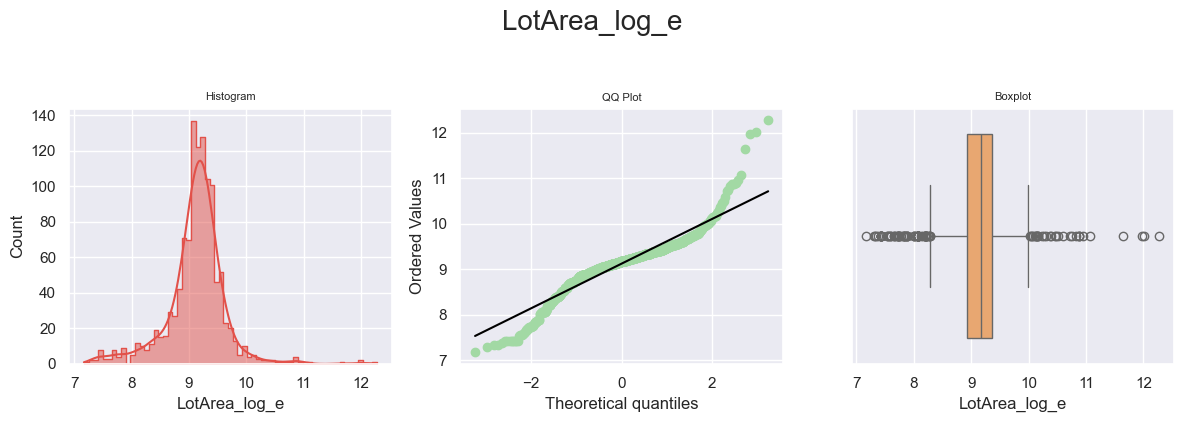

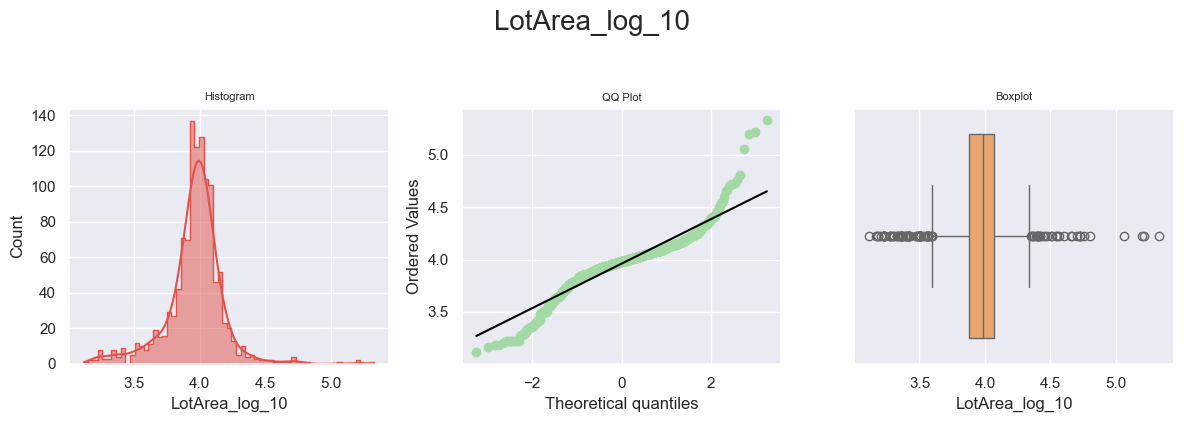

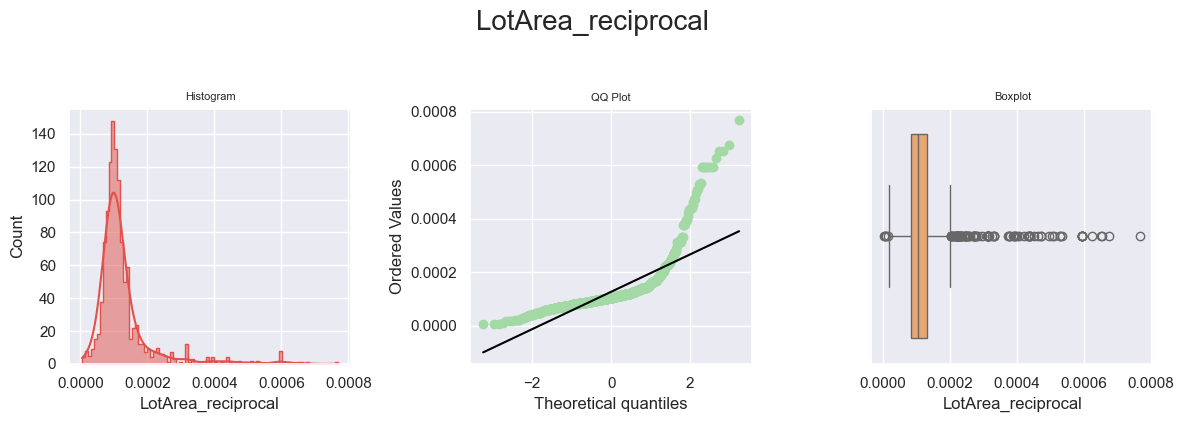

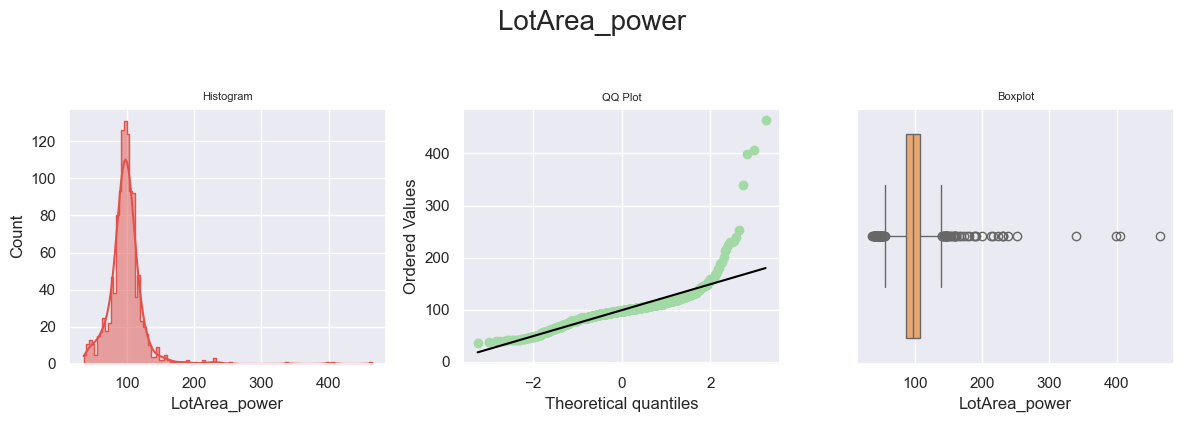

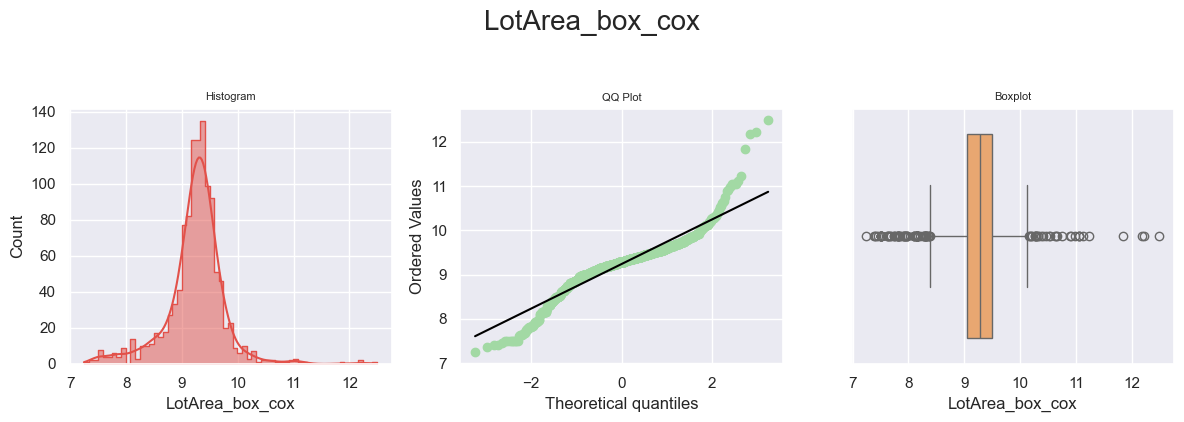

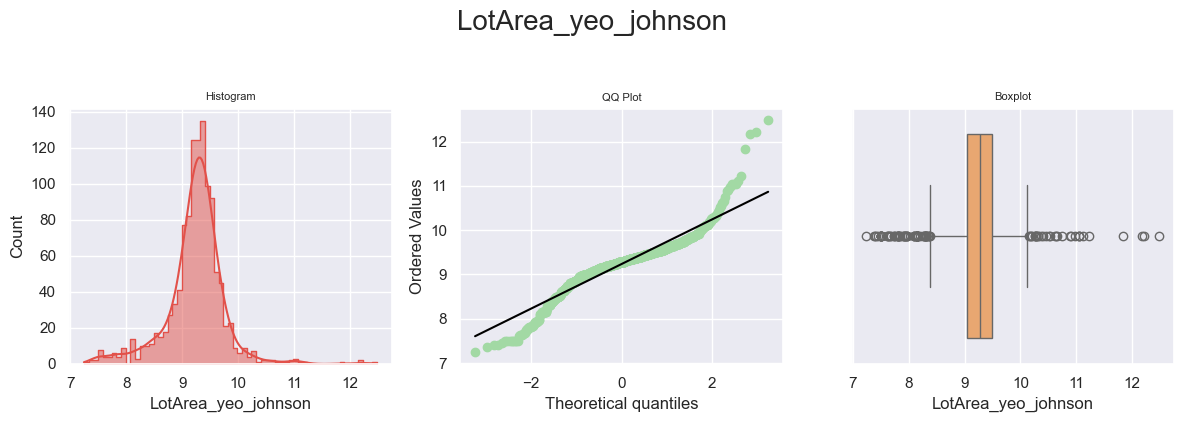



*** Variable Analyzed: LotFrontage
*** Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



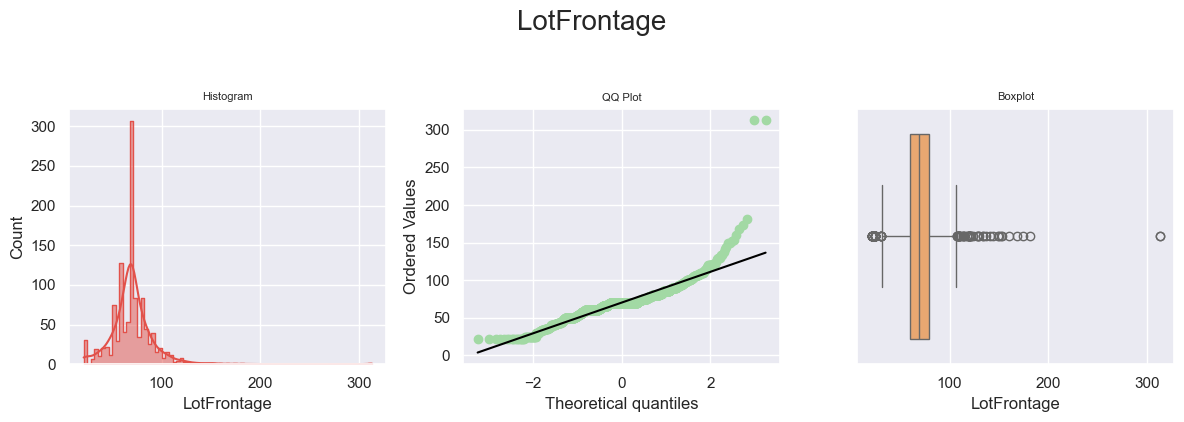

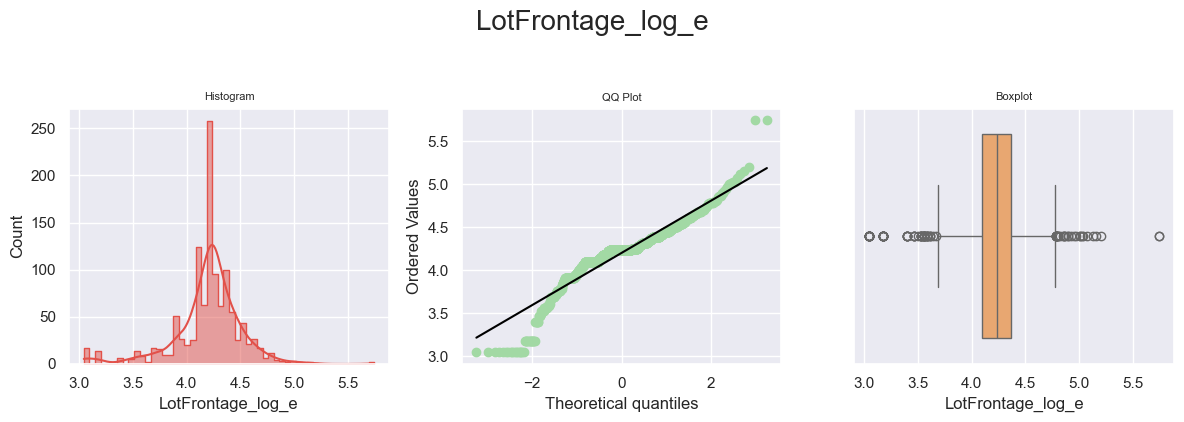

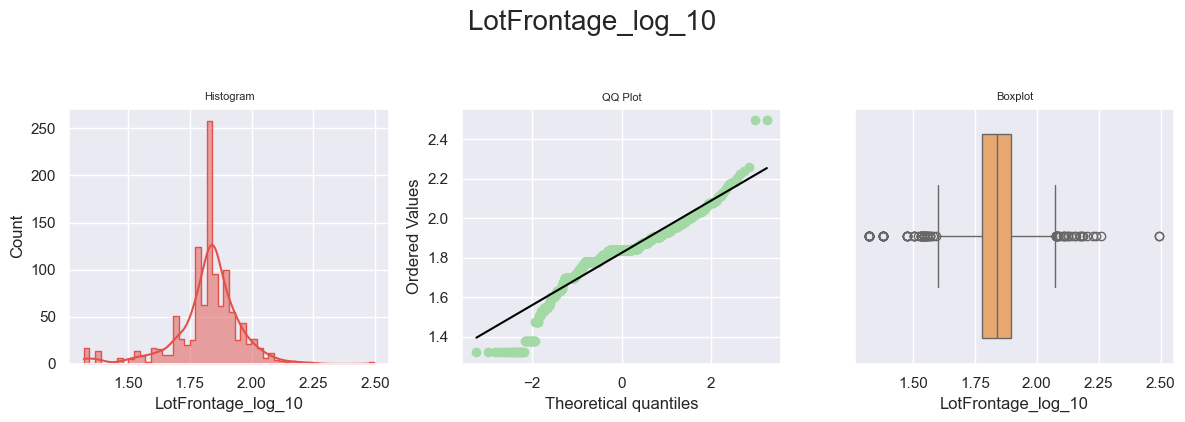

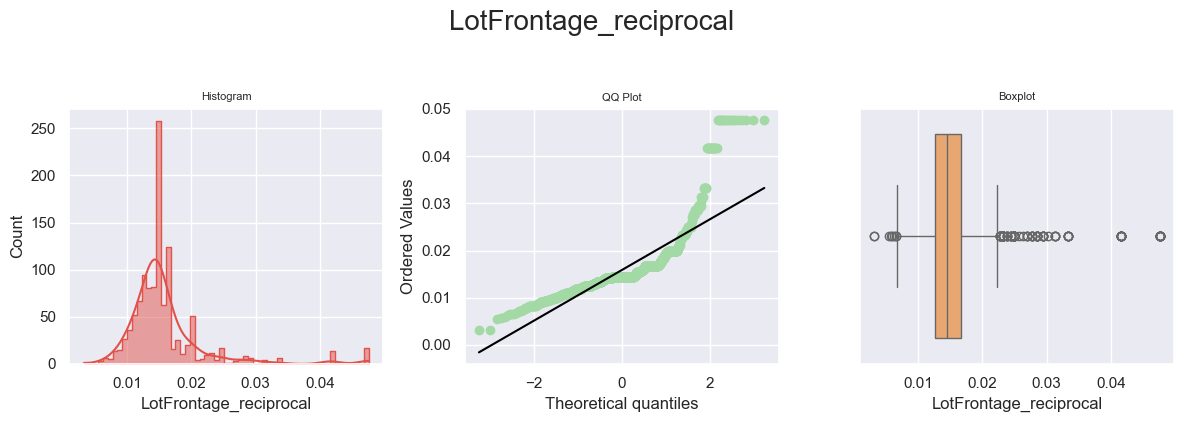

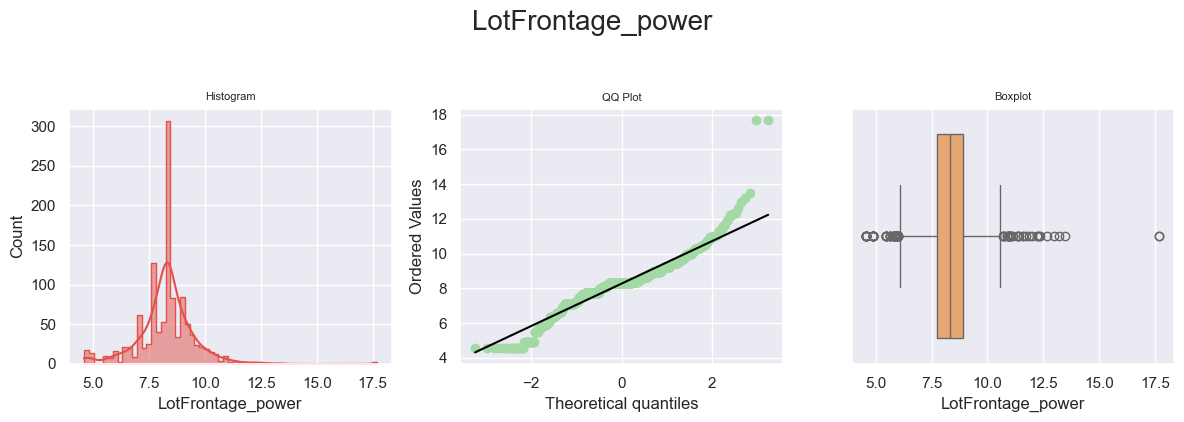

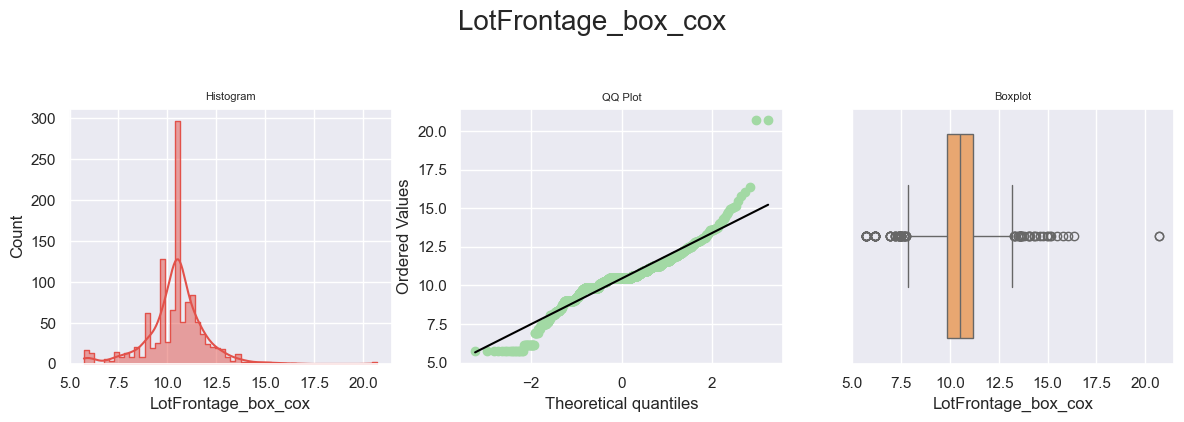

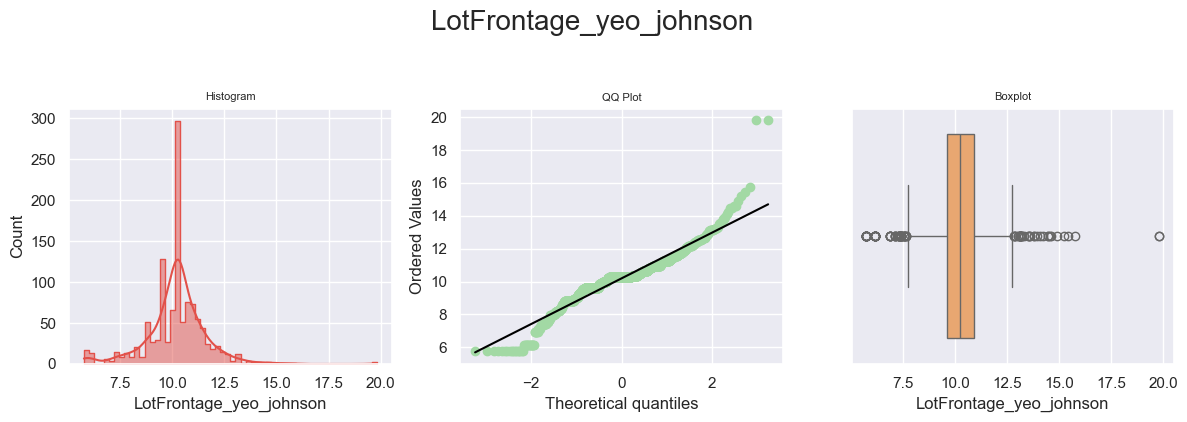



*** Variable Analyzed: GarageArea
*** Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



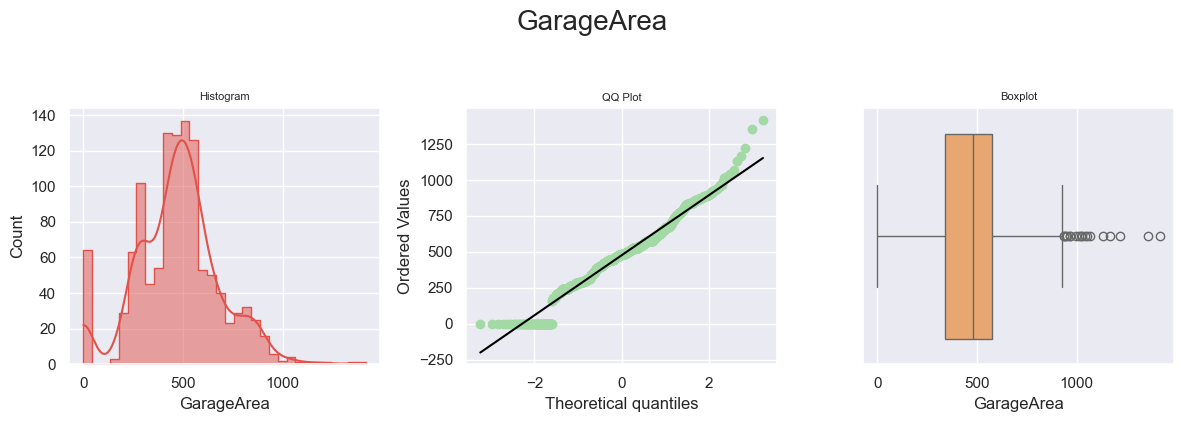

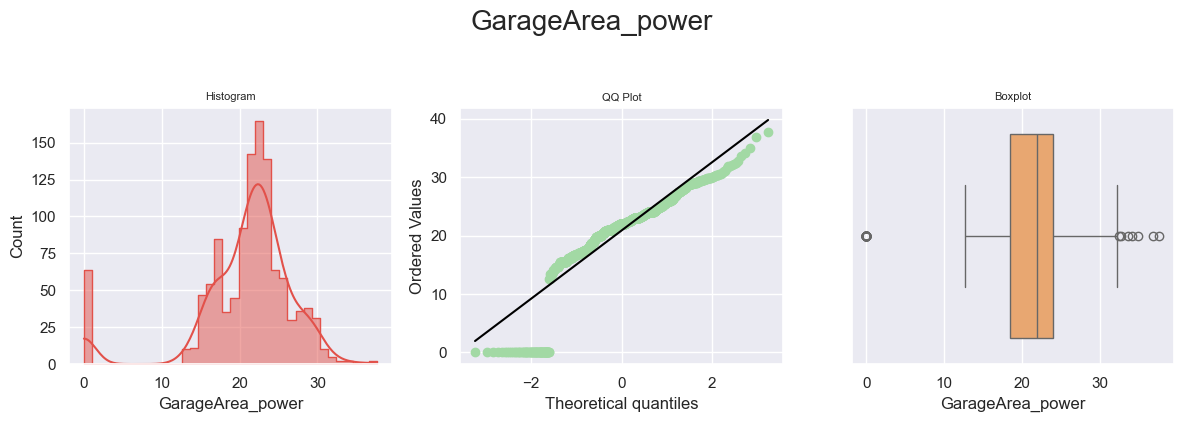

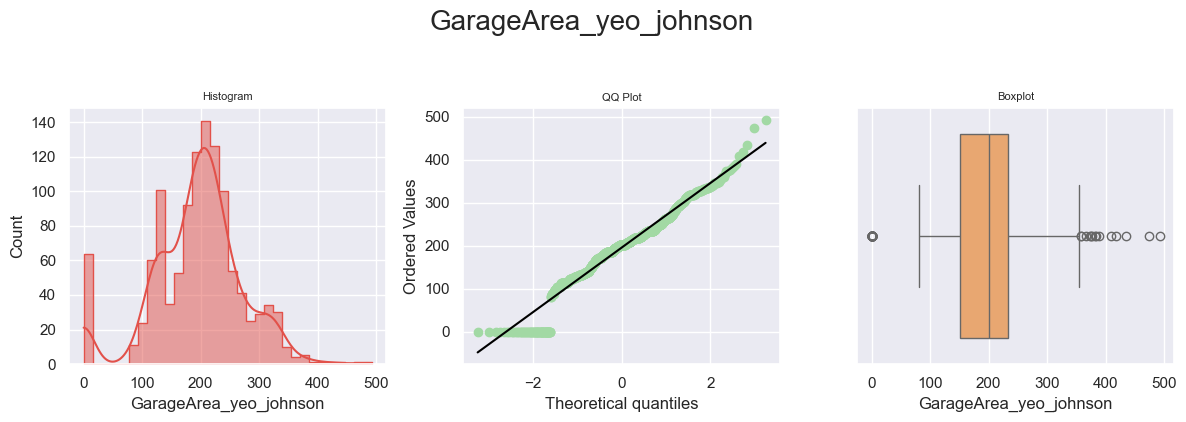



*** Variable Analyzed: MasVnrArea
*** Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



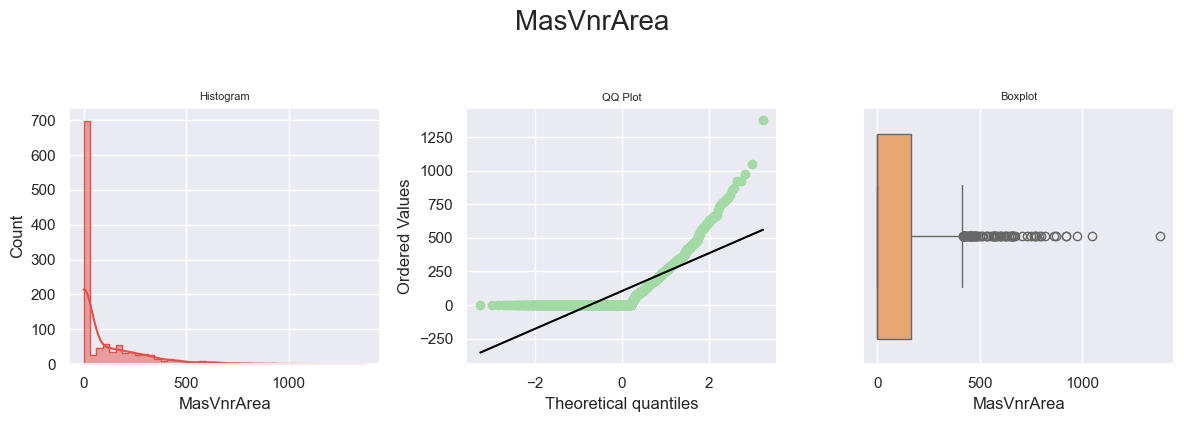

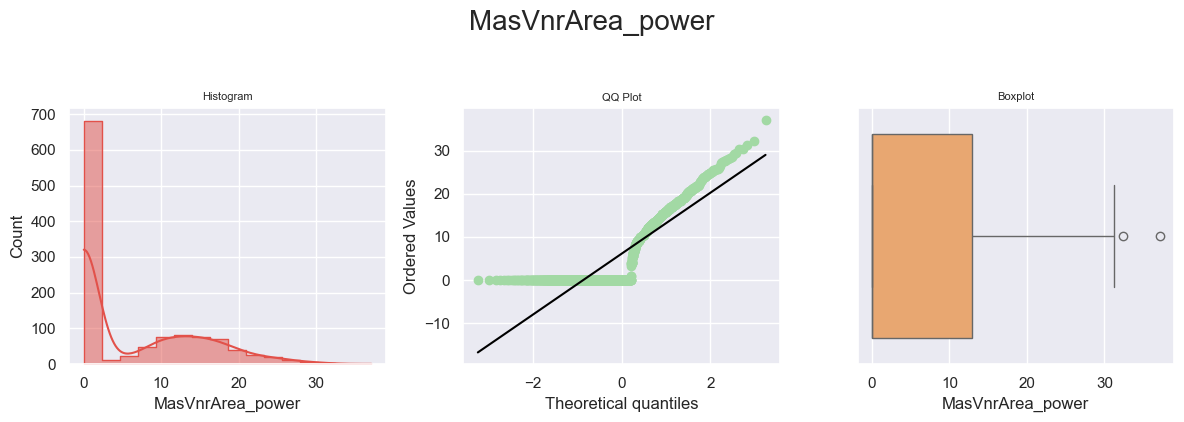

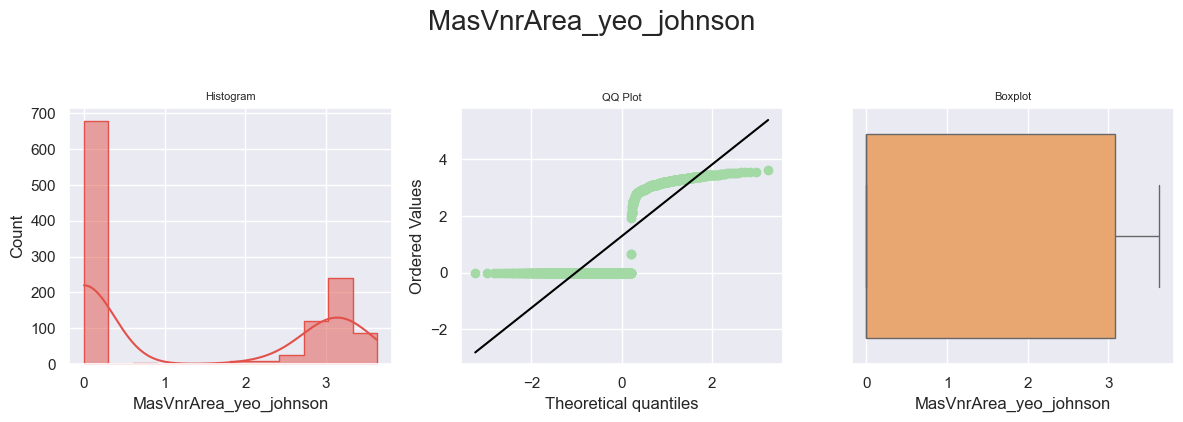



*** Variable Analyzed: OpenPorchSF
*** Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



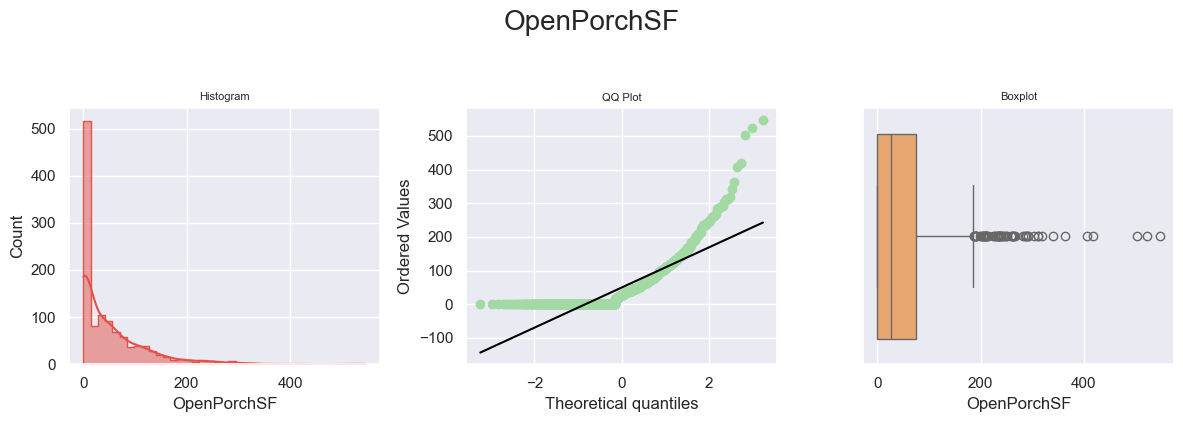

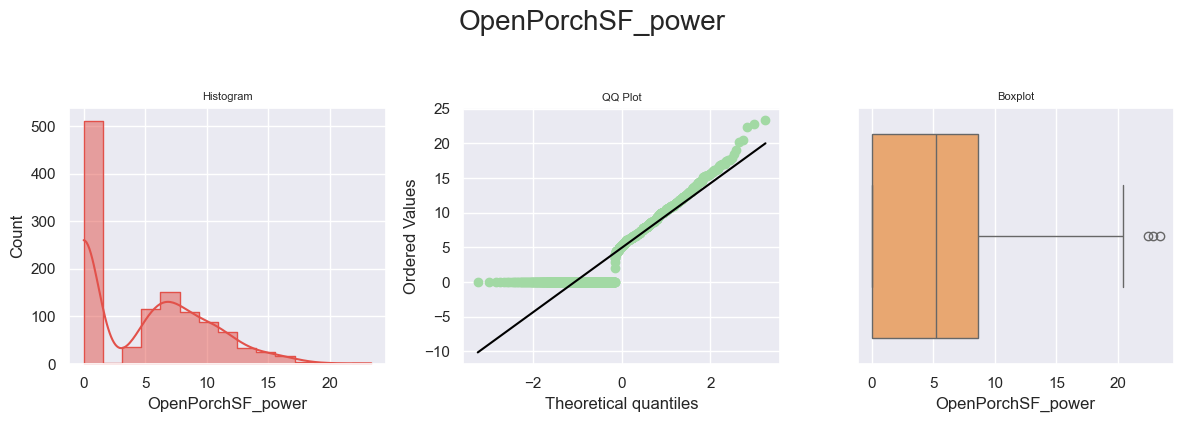

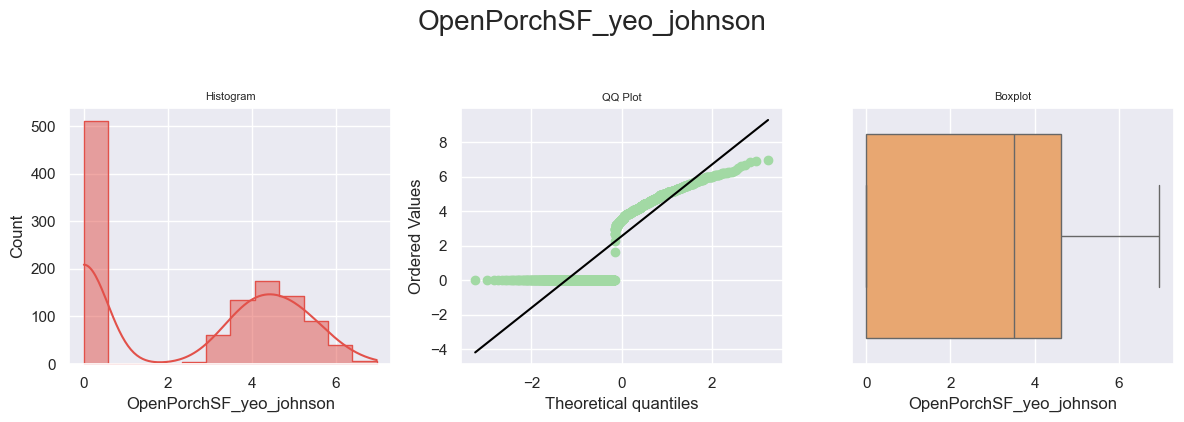



*** Variable Analyzed: TotalBsmtSF
*** Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



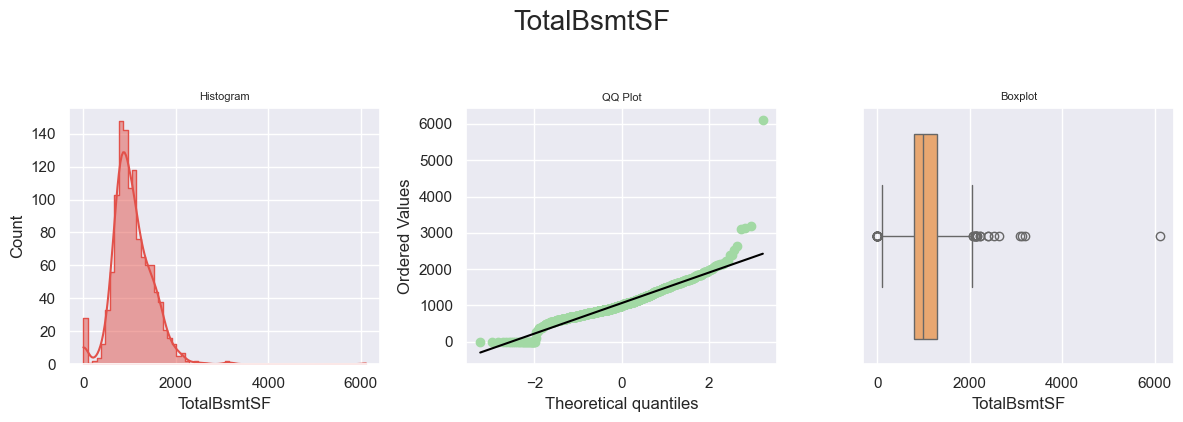

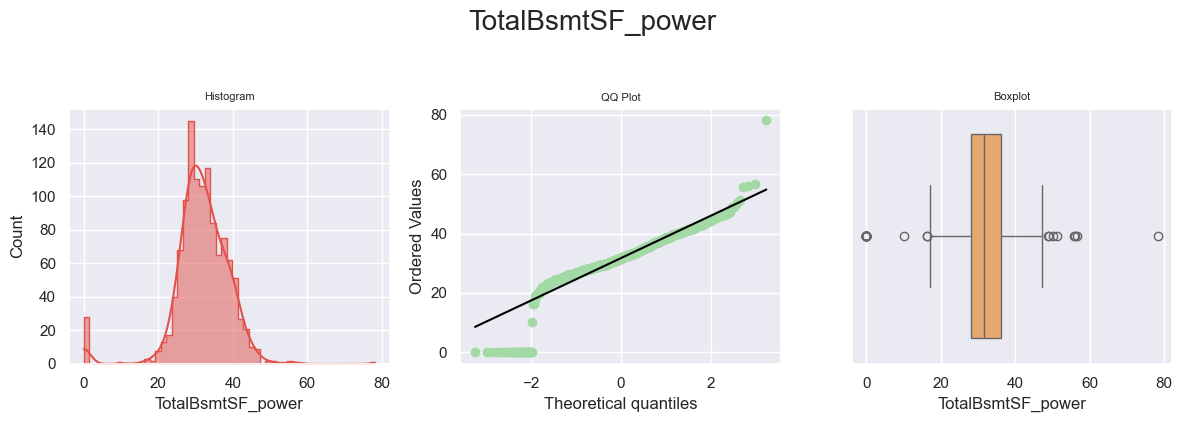

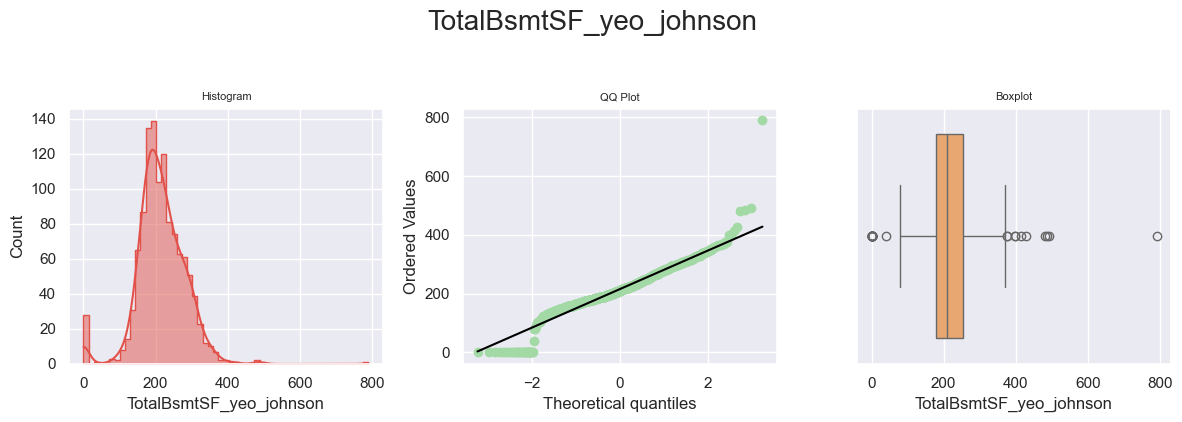

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Log and power transformations are applied to reduce skewness and stabilize variance in numerical variables. This improves the model's ability to learn patterns from the data and ensures consistent scaling across features.

In [20]:
lt = LogTransformer(variables=['GrLivArea', 'LotArea', 'LotFrontage'])
pt = PowerTransformer(variables=['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])

transformers = [lt, pt]
for t in transformers:
    TrainSet = t.fit_transform(TrainSet)
    TestSet = t.transform(TestSet)

print("*** Numerical transformation done!")

*** Numerical transformation done!


#### 2.2.3 Winsorization

Outliers can distort model performance by introducing noise. Winsorization caps extreme values to a specified range, reducing their impact while preserving the overall distribution of the data.

Starting by selecting variables with potential outliers.

In [21]:
variables_engineering = [
    'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea',
    'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'
    ]
variables_engineering

['GarageArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF']

Create a separate DataFrame containing only the selected variables and display the three rows.

In [22]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

GarageArea   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  TotalBsmtSF  \
0   17.146428  9.035987     4.248495         0.0     0.000000    36.249138   
1   19.493589  8.966611     4.077537         0.0     6.324555    28.266588   
2    0.000000  9.079890     4.204693         0.0     0.000000    28.213472   

    1stFlrSF   2ndFlrSF  
0  36.249138   0.000000  
1  28.266588  27.784888  
2  28.213472   0.000000

Apply Winsorization by calling `FeatureEngineeringAnalysis` function.

*** Variable Analyzed: GarageArea
*** Applied transformation: ['GarageArea_iqr'] 



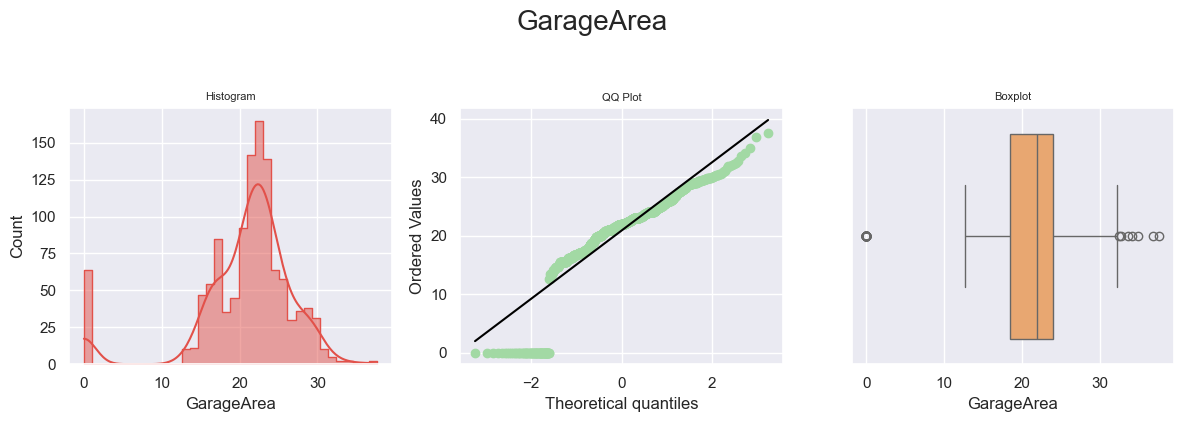

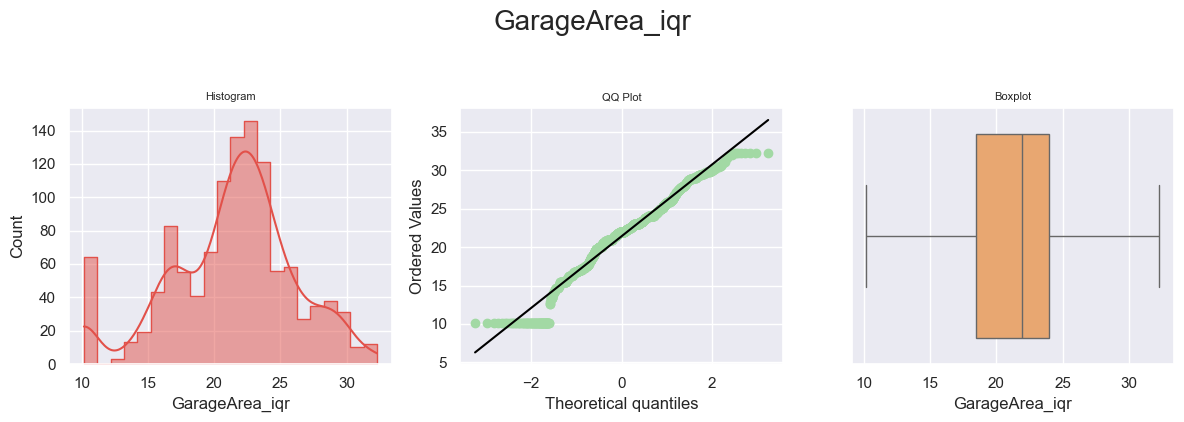



*** Variable Analyzed: LotArea
*** Applied transformation: ['LotArea_iqr'] 



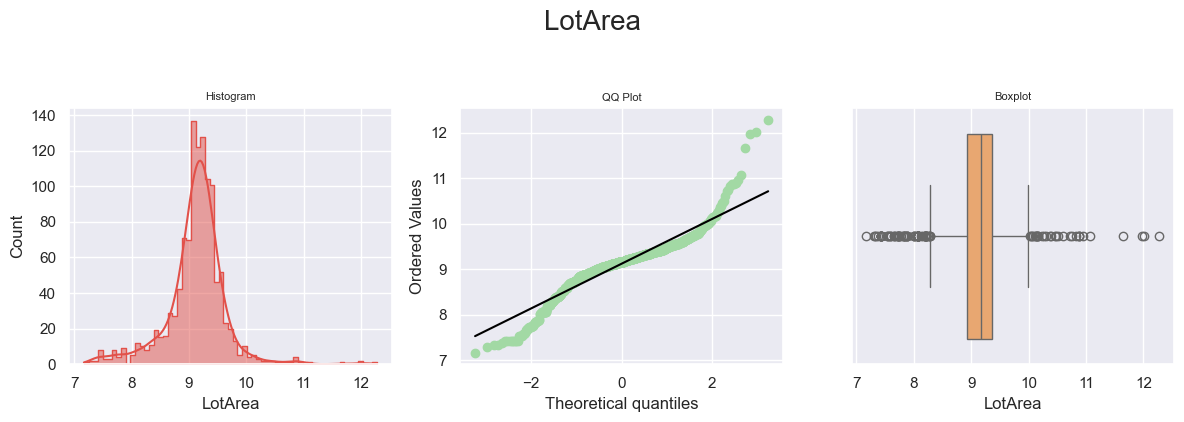

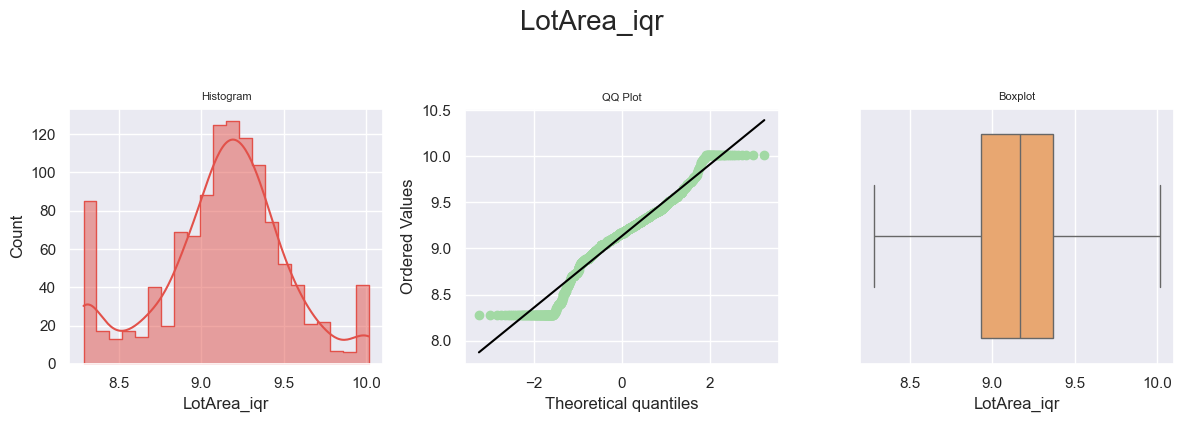



*** Variable Analyzed: LotFrontage
*** Applied transformation: ['LotFrontage_iqr'] 



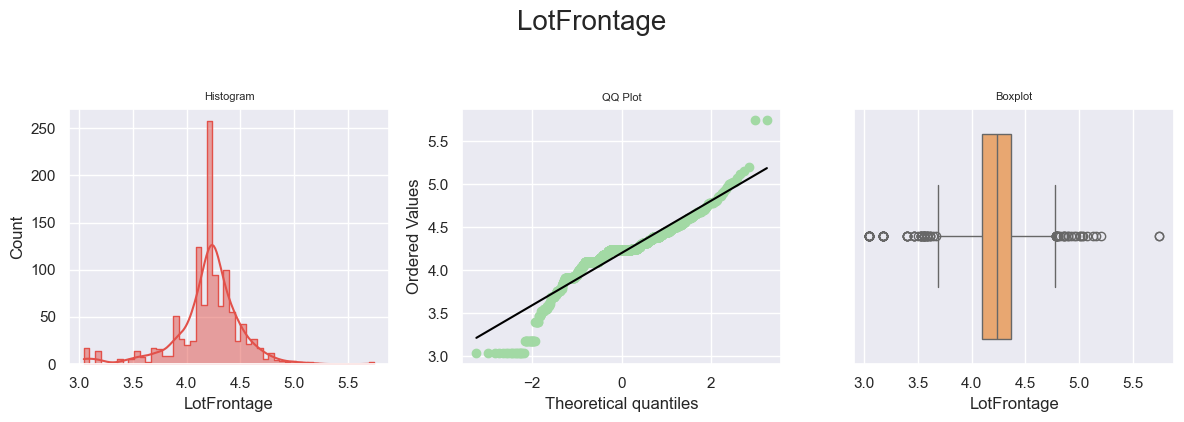

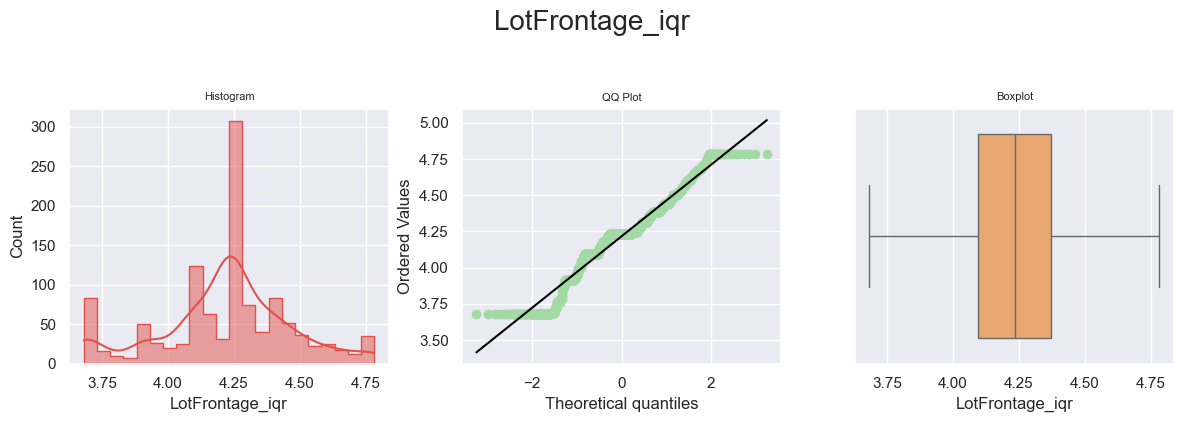



*** Variable Analyzed: MasVnrArea
*** Applied transformation: ['MasVnrArea_iqr'] 



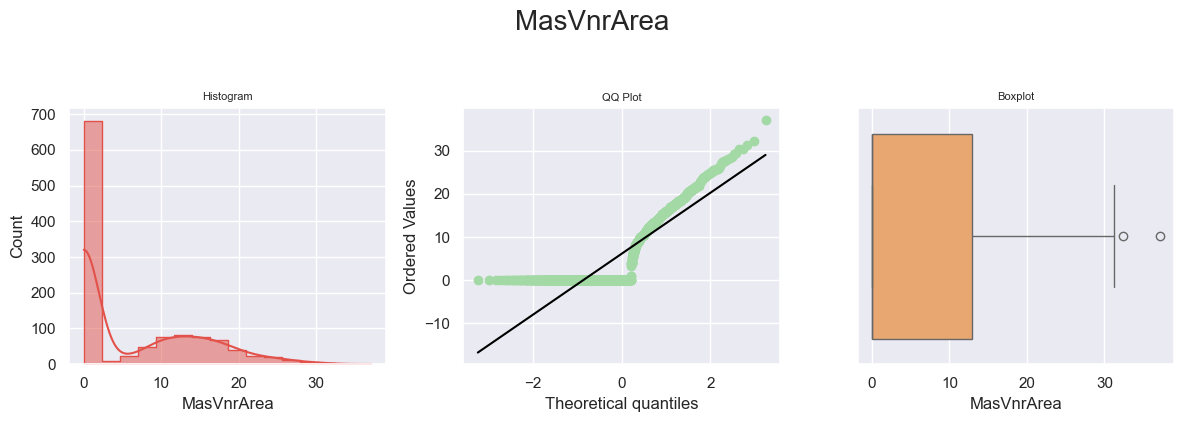

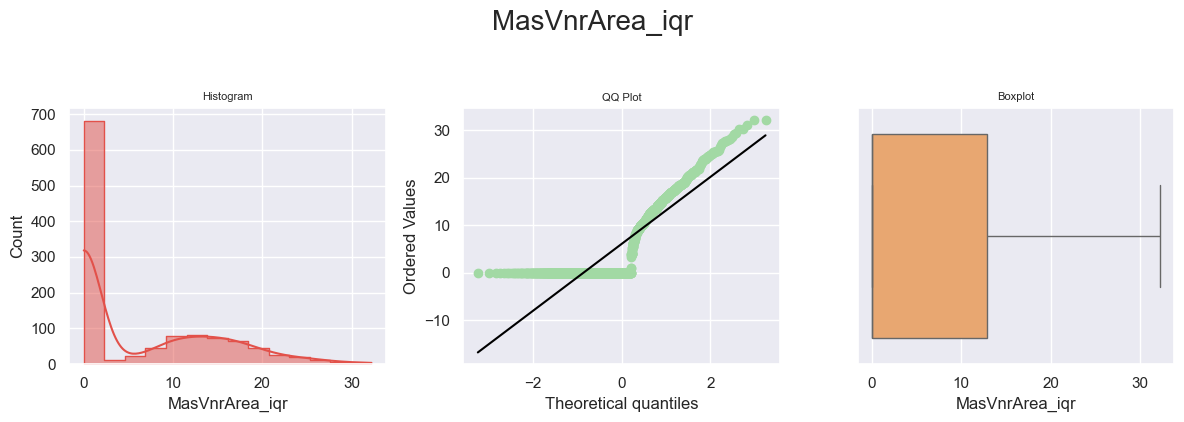



*** Variable Analyzed: OpenPorchSF
*** Applied transformation: ['OpenPorchSF_iqr'] 



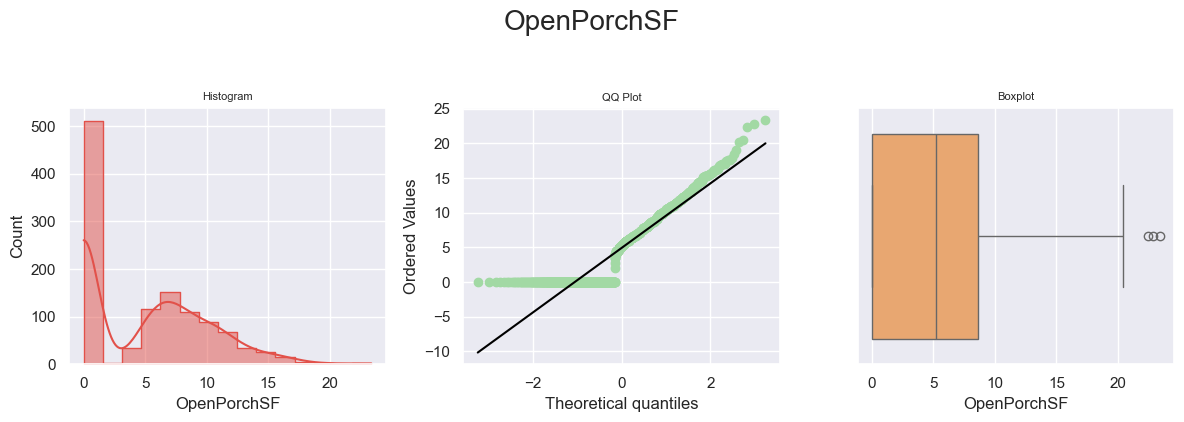

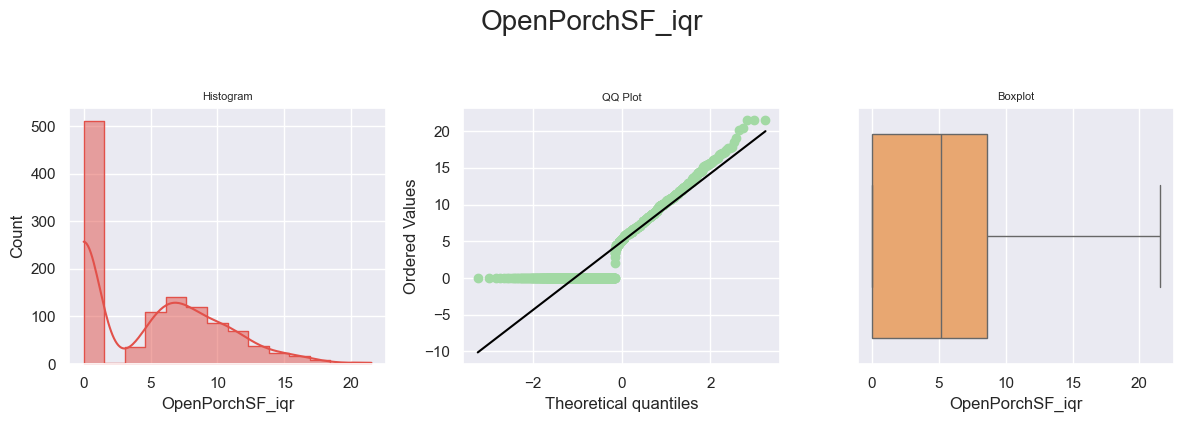



*** Variable Analyzed: TotalBsmtSF
*** Applied transformation: ['TotalBsmtSF_iqr'] 



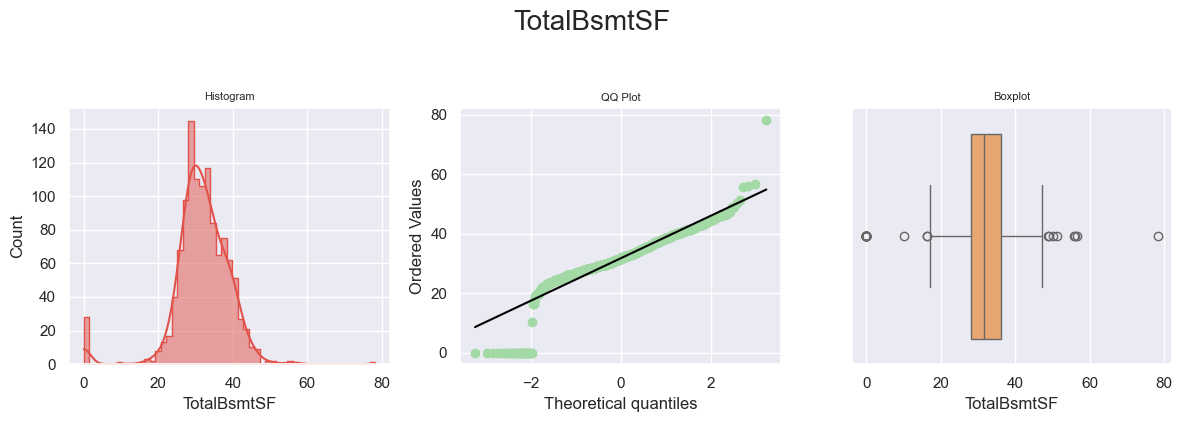

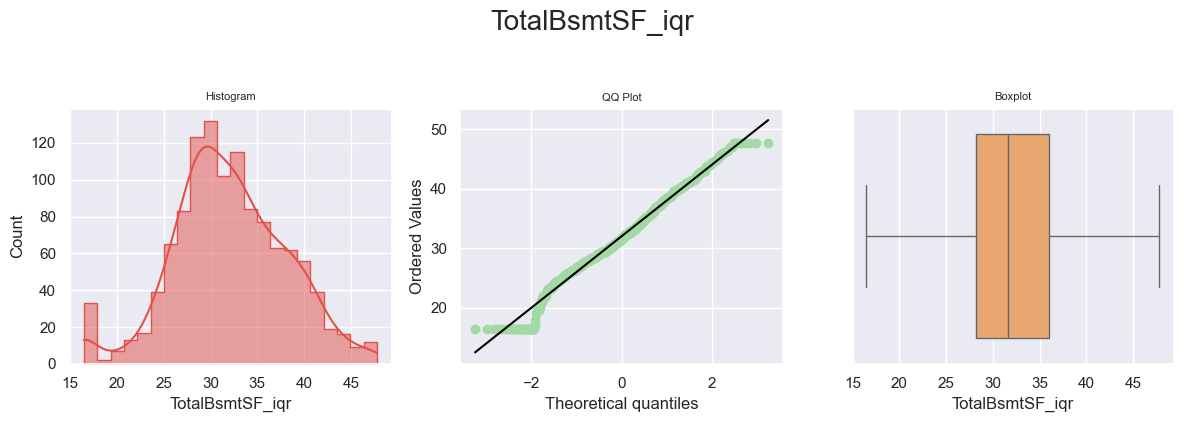



*** Variable Analyzed: 1stFlrSF
*** Applied transformation: ['1stFlrSF_iqr'] 



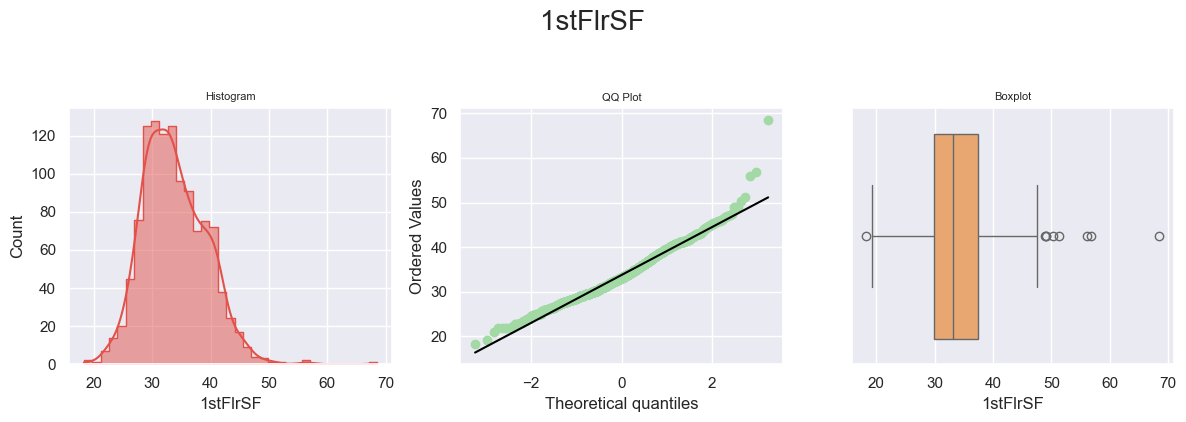

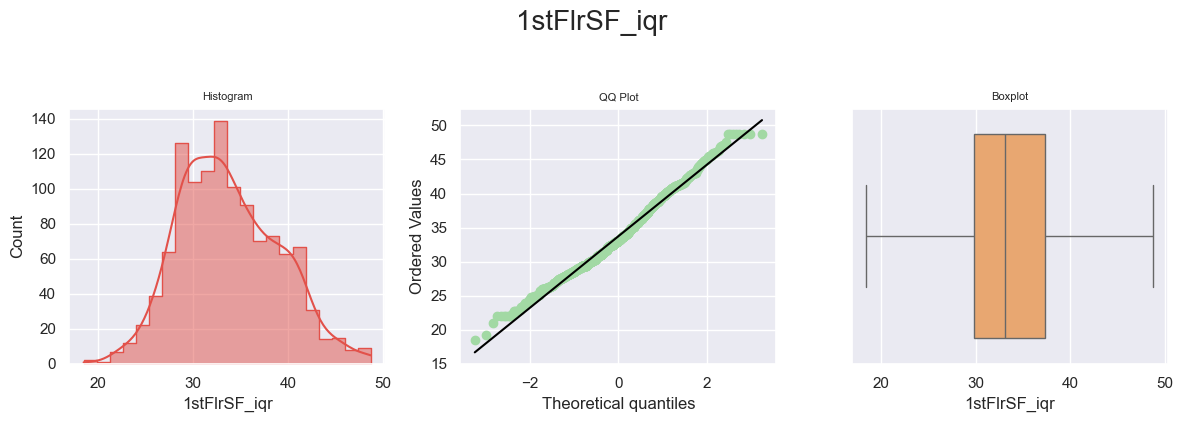



*** Variable Analyzed: 2ndFlrSF
*** Applied transformation: ['2ndFlrSF_iqr'] 



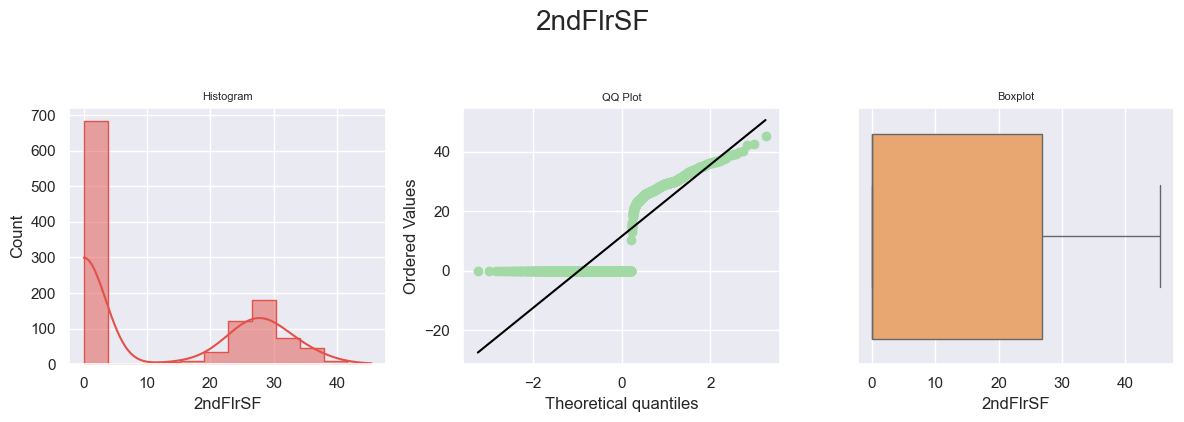

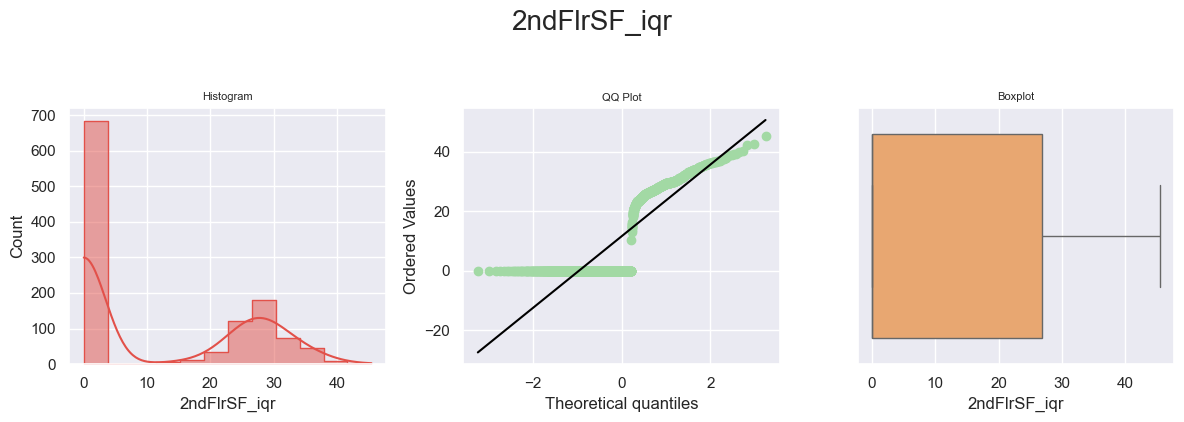

In [23]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

Apply the Winsorization to the Train and Test datasets.

In [24]:
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=variables_engineering)
TrainSet = winsorizer.fit_transform(TrainSet)
TestSet = winsorizer.transform(TestSet)

print("*** Winsorization done!")

*** Winsorization done!


#### 2.2.4 Smart Correlation Selection

Highly correlated features can introduce multicollinearity, which negatively impacts regression models. Smart Correlation Selection identifies and removes redundant features based on `Spearman` correlation, retaining the most informative variables.

We start by selecting variables.

In [25]:
variables_engineering = TrainSet.columns

Create a separate DataFrame containing only the selected variables and display the three rows.

In [26]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF   2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  36.249138   0.000000           3.0             0         922             0   
1  28.266588  27.784888           3.0             0           0             1   
2  28.213472   0.000000           2.0             0           0             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...   LotArea  \
0        392   17.146428             0       1957.0  ...  9.035987   
1        799   19.493589             0       1993.0  ...  8.966611   
2        796   10.165314             1          0.0  ...  9.079890   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0     4.248495         0.0     0.000000            6            5   
1     4.077537         0.0     6.324555            7            6   
2     4.204693         0.0     0.000000            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0    36.249138       1957          1957     145000  
1    28.266588       1993          1994     178000  
2    28.213472       1910          1950      85000  

[3 rows x 22 columns]

Create engineered variables by applying the transformations.

In [27]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8, selection_method="variance")

df_engineering = corr_sel.fit_transform(df_engineering)
print("Correlated feature sets:", corr_sel.correlated_feature_sets_)
print("Features to drop:", corr_sel.features_to_drop_)

Correlated feature sets: [{'1stFlrSF', 'TotalBsmtSF'}, {'GarageYrBlt', 'YearBuilt'}, {'SalePrice', 'OverallQual'}]
Features to drop: ['1stFlrSF', 'OverallQual', 'YearBuilt']


Update `TrainSet` and `TestSet` with selected variables. Additionally, print correlated feature sets, dropped features and lastly a confirmation message.

In [28]:
TrainSet = TrainSet[df_engineering.columns]
TestSet = TestSet[df_engineering.columns]

print("*** Smart Correlation Selection done!")

*** Smart Correlation Selection done!


---

## Conclusion and Next Steps

### Conclusions
We successfully engineered features to improve the predictive power of the dataset and prepared it for regression modeling. Key steps included handling missing values, transforming numerical variables, encoding categorical variables, and addressing multicollinearity. These steps ensure the dataset is clean, well-structured, and ready for the next phase of model training and evaluation.

#### Key observations include:
1. **Categorical Encoding**: Ordinal encoding was applied to variables like `GarageFinish` and `KitchenQual`, preserving the natural order of categories. This ensures that the encoded values reflect the hierarchy of the original categories, which is critical for regression models.
2. **Numerical Transformations**: Log and power transformations effectively reduced skewness and stabilized variance in variables like `GrLivArea` and `LotArea`.
3. **Outlier Handling**: Winsorization successfully capped extreme values in variables like `GarageArea` and `MasVnrArea`, reducing their impact on the model.
4. **Feature Selection**: Smart Correlation Selection removed redundant features, ensuring the final dataset is free from multicollinearity.


### Next steps: Model Training and Evaluation
1. **Model Training**: Train a regression model using the engineered features to predict house prices and experiment with different algorithms (e.g., linear regression, random forest) to identify the best-performing model.
2. **Model Evaluation**: Evaluate the model's performance using metrics like RMSE, MAE, and R². Additionally, perform cross-validation to ensure the model generalizes well to unseen data.